# LIBRARIES

In [851]:
import zipfile
import os
import io
import sys
import warnings
import requests

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

# GET DATA

The following functions were used to load the data in as a text file, convert to a csv, then zip the csv.

This was done because the method eBird uses to send data is through text files, as their datafiles are very large. 

Since this process only needs to occur once, these functions are no longer useful or needed, but for the purpose of documenting work, they have been saved as MDs. 

def txt_to_csv(input_file_name, output_file_name, delimiter='\t', header=True):
    # Get the current working directory
    cwd = os.getcwd()

    # Create full file paths
    input_file_path = os.path.join(cwd, input_file_name)
    output_file_path = os.path.join(cwd, output_file_name)

    # Read the text file
    header_row = 0 if header else None
    df = pd.read_csv(input_file_path, delimiter=delimiter, header=header_row)

    # Save the dataframe to a CSV file
    df.to_csv(output_file_path, index=False)

txt_to_csv('NORCAR_JAN.txt', 'NORCAR_JAN.csv')
txt_to_csv('NORCAR_APRIL.txt', 'NORCAR_APRIL.csv')
txt_to_csv('NORCAR_JUL.txt', 'NORCAR_JUL.csv')
txt_to_csv('NORCAR_OCT.txt', 'NORCAR_OCT.csv')

def zip_csv(input_csv, output_zip):
    # Read the CSV into a DataFrame
    df = pd.read_csv(input_csv)

    # No need to identify and filter by top species; we skip that step

    # Create a buffer to write the DataFrame to
    buffer = io.StringIO()
    df.to_csv(buffer, index=False)
    buffer.seek(0)  # Rewind the buffer

    # Zip the buffered CSV
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.writestr(os.path.basename(input_csv), buffer.getvalue())
        

zip_csv('NORCAR_JAN.csv', 'NORCAR_JAN.zip')
zip_csv('NORCAR_APRIL.csv', 'NORCAR_APRIL.zip')
zip_csv('NORCAR_JUL.csv', 'NORCAR_JUL.zip')
zip_csv('NORCAR_OCT.csv', 'NORCAR_OCT.zip')

# PROCESS AND CLEAN DATA

## Bird Data
---

### Read the Data in from Links

n = 982,667

In [ ]:
def read_csv_from_zip_url(url):
    """
    This function obtains a zipped csv from a URL. 
    It is assumed that there is only one csv in the zipped folder. 
    Additionally, this function reads the csv into a variable instead of loading a csv into your operating system. 
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
        # Assuming there's only one file in the zip
        csv_file_name = zipf.namelist()[0]
        with zipf.open(csv_file_name) as csv_file:
            return pd.read_csv(csv_file)
        
# read the CSVs in from URLs
NORCAR_JAN = read_csv_from_zip_url('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/NORCAR_JAN.zip')
NORCAR_APRIL = read_csv_from_zip_url('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/NORCAR_APRIL.zip')
NORCAR_JUL = read_csv_from_zip_url('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/NORCAR_JUL.zip')
NORCAR_OCT = read_csv_from_zip_url('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/NORCAR_OCT.zip')

# concat each of the dataframes
NORCAR_DATA = pd.concat([NORCAR_JAN, NORCAR_APRIL, NORCAR_JUL, NORCAR_OCT], ignore_index=True)

# breifly take a look at the dataframe
print(NORCAR_DATA.columns)
NORCAR_DATA

### Bird Data Cleaning

n = 2286

In [486]:
def ebird_data_processor(data):
    """
    Example usage: 
    ebird_data_processor(OK_Data)
    
    This function cleans ebird data. The following list shows what this function executes within the dataframe: 
    - Converts the observation counts to numeric data, and explaces 'X' with '0'
    - Replaces spaces with '_'
    - Creates a month column that names the months by their English names
    - Drops unnecessary columns
    """
    
    data.columns = data.columns.str.replace(' ', '_')
    data['OBSERVATION_COUNT'] = pd.to_numeric(data['OBSERVATION_COUNT'].str.replace('X', '0').str.strip())
    data['OBSERVATION_DATE'] = pd.to_datetime(data['OBSERVATION_DATE'])
    data['MONTH'] = data['OBSERVATION_DATE'].dt.strftime('%B')
    

    # Columns to drop
    columns_to_drop = ['LAST_EDITED_DATE', 'TAXONOMIC_ORDER', 'CATEGORY', 'TAXON_CONCEPT_ID',
                       'SUBSPECIES_COMMON_NAME', 'SUBSPECIES_SCIENTIFIC_NAME', 'EXOTIC_CODE',
                       'BREEDING_CODE', 'BREEDING_CATEGORY', 'BEHAVIOR_CODE', 'AGE/SEX', 'COUNTRY', 
                       'COUNTRY_CODE', 'COUNTY_CODE', 'IBA_CODE', 'BCR_CODE',
                       'ATLAS_BLOCK', 'LOCALITY', 'LOCALITY_ID', 'USFWS_CODE', 'LOCALITY_TYPE',
                       'SAMPLING_EVENT_IDENTIFIER', 'PROTOCOL_TYPE', 'PROTOCOL_CODE', 'PROJECT_CODE',
                       'EFFORT_AREA_HA', 'ALL_SPECIES_REPORTED', 'GROUP_IDENTIFIER', 'HAS_MEDIA', 
                       'APPROVED', 'REVIEWED', 'REASON', 'TRIP_COMMENTS', 'SPECIES_COMMENTS', 
                       'Unnamed:_49']

    data = data.drop(columns=columns_to_drop, errors='ignore')
    
    #aggregate by state and county
    county_aggregate = data.groupby(['STATE', 'COUNTY']).agg({
    'OBSERVATION_COUNT': 'sum',  # Sum of observation counts
    'DURATION_MINUTES': 'mean',  # Average duration in minutes
    'EFFORT_DISTANCE_KM': 'mean' # Average effort distance in km
    })
    
    #reset index
    county_aggregate = county_aggregate.reset_index()
    
    # renaming the columns to match the name of the county dataset
    county_aggregate = county_aggregate.rename(columns={'STATE': 'State', 'COUNTY': 'Area_Name'})
    
    
    # filter for counties with higher than a 10 observation count
    county_aggregate = county_aggregate[county_aggregate['OBSERVATION_COUNT'] >= 10]
    
    # filter out states that northern cardinals are known to not frequent
    states_to_drop = ['Washington', 'Oregon', 'Idaho', 'Montana', 'Utah', 
                  'California', 'Wyoming', 'Hawaii', 'Alaska']
    county_aggregate = county_aggregate.drop(county_aggregate[county_aggregate['State'].isin(states_to_drop)].index)
    
    # filter out the top and bottom 1%
    df_sorted = county_aggregate.sort_values(by='OBSERVATION_COUNT')
    one_percent_count = int(len(merged_data) * 0.01)
    bottom_1_percent_indices = df_sorted.head(one_percent_count).index
    top_1_percent_indices = df_sorted.tail(one_percent_count).index
    
    df_cleaned = county_aggregate.drop(bottom_1_percent_indices).drop(top_1_percent_indices)

    return df_cleaned


In [862]:
NORCAR_DATA_PROCESSED = ebird_data_processor(NORCAR_DATA)
NORCAR_DATA_PROCESSED

,State,Area_Name,OBSERVATION_COUNT,DURATION_MINUTES,EFFORT_DISTANCE_KM
0,Alabama,Autauga,257,44.084906,3.451288
1,Alabama,Baldwin,11045,81.141732,3.018089
2,Alabama,Barbour,524,107.030000,5.437315
3,Alabama,Bibb,79,94.555556,3.155542
4,Alabama,Blount,68,76.000000,8.819000
...,...,...,...,...,...
2564,Wisconsin,Waukesha,4515,62.212963,2.789457
2565,Wisconsin,Waupaca,332,59.464968,2.998825
2566,Wisconsin,Waushara,208,56.226190,1.531000
2567,Wisconsin,Winnebago,2299,59.635112,2.185638


## COUNTY DATA
---


### Read in County Data from CSV Link

n = 3143

columns # = 54

In [860]:
Population_Estimates = pd.read_csv('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/PopulationEstimates.csv')
Population_Estimates

,FIPStxt,State_Code,State,Area_Name,Rural_Urban_Continuum_Code_2003,Rural_Urban_Continuum_Code_2013,Urban_Influence_2003,Urban_Influence_2013,Economic_typology_2015,CENSUS_2020_POP,...,R_DEATH_2021,R_DEATH_2022,R_NATURAL_CHG_2021,R_NATURAL_CHG_2022,R_INTERNATIONAL_MIG_2021,R_INTERNATIONAL_MIG_2022,R_DOMESTIC_MIG_2021,R_DOMESTIC_MIG_2022,R_NET_MIG_2021,R_NET_MIG_2022
0,1001,AL,Alabama,Autauga County,2.0,2.0,2.0,2.0,0.0,"58,805",...,11.5,11.3,0.2,0.6,0.3,0.5,4.1,8.5,4.3,9.0
1,1003,AL,Alabama,Baldwin County,4.0,3.0,5.0,2.0,5.0,"231,767",...,12.9,12.0,-2.9,-2.1,0.4,1.3,29.5,28.7,29.9,30.0
2,1005,AL,Alabama,Barbour County,6.0,6.0,6.0,6.0,3.0,"25,223",...,15.5,15.1,-4.3,-3.9,0.0,0.2,-12.4,9.9,-12.4,10.0
3,1007,AL,Alabama,Bibb County,1.0,1.0,1.0,1.0,0.0,"22,293",...,14.3,14.5,-3.3,-3.3,0.0,0.1,11.6,-13.6,11.7,-13.5
4,1009,AL,Alabama,Blount County,1.0,1.0,1.0,1.0,0.0,"59,134",...,14.6,14.2,-3.5,-2.9,0.2,0.2,2.4,10.0,2.5,10.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Wyoming,Sweetwater County,5.0,5.0,8.0,8.0,2.0,"42,272",...,10.1,10.5,0.7,0.4,0.4,1.2,-15.3,-7.2,-14.9,-6.0
3139,56039,WY,Wyoming,Teton County,7.0,7.0,8.0,8.0,5.0,"23,331",...,4.0,4.5,5.4,4.7,0.3,1.1,4.6,-20.3,4.8,-19.2
3140,56041,WY,Wyoming,Uinta County,7.0,7.0,8.0,8.0,2.0,"20,450",...,9.0,9.6,2.0,1.3,0.0,-0.2,7.2,2.0,7.2,1.8
3141,56043,WY,Wyoming,Washakie County,7.0,7.0,11.0,11.0,0.0,"7,685",...,14.3,14.9,-4.8,-5.2,0.0,-0.1,12.0,6.7,12.0,6.6


### County Data Cleaning

In [861]:
def County_Data_Processor(df):
    
    df['Area_Name'] = df['Area_Name'].str.replace(' County', '', regex=False)
    

    columns_to_drop = [
        'POP_ESTIMATE_2020', 'POP_ESTIMATE_2021',
        'N_POP_CHG_2020', 'N_POP_CHG_2021', 'N_POP_CHG_2022',
        'BIRTHS_2020', 'BIRTHS_2021', 'BIRTHS_2022',
        'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022',
        'NATURAL_CHG_2020', 'NATURAL_CHG_2021',
        'INTERNATIONAL_MIG_2020', 'INTERNATIONAL_MIG_2021', 'INTERNATIONAL_MIG_2022',
        'DOMESTIC_MIG_2020', 'DOMESTIC_MIG_2021', 'DOMESTIC_MIG_2022',
        'NET_MIG_2020', 'NET_MIG_2021',
        'RESIDUAL_2020', 'RESIDUAL_2021', 'RESIDUAL_2022',
        'GQ_ESTIMATES_BASE_2020', 'GQ_ESTIMATES_2020', 'GQ_ESTIMATES_2021', 'GQ_ESTIMATES_2022',
        'R_BIRTH_2021', 'R_BIRTH_2022', 'R_DEATH_2021', 'R_DEATH_2022',
        'R_NATURAL_CHG_2021',
        'R_INTERNATIONAL_MIG_2021', 'R_INTERNATIONAL_MIG_2022',
        'R_DOMESTIC_MIG_2021', 'R_DOMESTIC_MIG_2022',
        'R_NET_MIG_2021', 'Rural_Urban_Continuum_Code_2003', 'Urban_Influence_2003',
        'ESTIMATES_BASE_2020', 'Census_2020_POP', 'POP_ESTIMATE_2022', 'NATURAL_CHG_2022', 
        'NET_MIG_2022'
    ]

    df = df.drop(columns=columns_to_drop)
    
    
    return df
    

In [490]:
County_Data_Processed = County_Data_Processor(Population_Estimates)
County_Data_Processed

,FIPStxt,State_Code,State,Area_Name,Rural_Urban_Continuum_Code_2013,Urban_Influence_2013,Economic_typology_2015,CENSUS_2020_POP,POP_ESTIMATE_2022,NATURAL_CHG_2022,NET_MIG_2022,R_NATURAL_CHG_2022,R_NET_MIG_2022
0,1001,AL,Alabama,Autauga,2.0,2.0,0.0,"58,805","59,759",36,535,0.6,9.0
1,1003,AL,Alabama,Baldwin,3.0,2.0,5.0,"231,767","246,435",-498,"7,297",-2.1,30.0
2,1005,AL,Alabama,Barbour,6.0,6.0,3.0,"25,223","24,706",-95,247,-3.9,10.0
3,1007,AL,Alabama,Bibb,1.0,1.0,0.0,"22,293","22,005",-73,-299,-3.3,-13.5
4,1009,AL,Alabama,Blount,1.0,1.0,0.0,"59,134","59,512",-170,606,-2.9,10.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Wyoming,Sweetwater,5.0,8.0,2.0,"42,272","41,345",17,-249,0.4,-6.0
3139,56039,WY,Wyoming,Teton,7.0,8.0,5.0,"23,331","23,287",111,-451,4.7,-19.2
3140,56041,WY,Wyoming,Uinta,7.0,8.0,2.0,"20,450","20,712",27,38,1.3,1.8
3141,56043,WY,Wyoming,Washakie,7.0,11.0,0.0,"7,685","7,719",-40,51,-5.2,6.6


## MERGE DATA
---

In [491]:
def df_merger(df1, df2):
    
    merged_data = pd.merge(df1, df2, on=['State', 'Area_Name'], how='inner')
    
    return merged_data

In [492]:
county_norcar_merged = df_merger(County_Data_Processed, NORCAR_DATA_PROCESSED)
county_norcar_merged

,FIPStxt,State_Code,State,Area_Name,Rural_Urban_Continuum_Code_2013,Urban_Influence_2013,Economic_typology_2015,CENSUS_2020_POP,POP_ESTIMATE_2022,NATURAL_CHG_2022,NET_MIG_2022,R_NATURAL_CHG_2022,R_NET_MIG_2022,OBSERVATION_COUNT,DURATION_MINUTES,EFFORT_DISTANCE_KM
0,1001,AL,Alabama,Autauga,2.0,2.0,0.0,"58,805","59,759",36,535,0.6,9.0,257,44.084906,3.451288
1,1003,AL,Alabama,Baldwin,3.0,2.0,5.0,"231,767","246,435",-498,"7,297",-2.1,30.0,11045,81.141732,3.018089
2,1005,AL,Alabama,Barbour,6.0,6.0,3.0,"25,223","24,706",-95,247,-3.9,10.0,524,107.030000,5.437315
3,1007,AL,Alabama,Bibb,1.0,1.0,0.0,"22,293","22,005",-73,-299,-3.3,-13.5,79,94.555556,3.155542
4,1009,AL,Alabama,Blount,1.0,1.0,0.0,"59,134","59,512",-170,606,-2.9,10.2,68,76.000000,8.819000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,55133,WI,Wisconsin,Waukesha,1.0,1.0,0.0,"406,978","410,434",-496,"2,112",-1.2,5.2,4515,62.212963,2.789457
2184,55135,WI,Wisconsin,Waupaca,6.0,6.0,3.0,"51,812","51,488",-346,-137,-6.7,-2.6,332,59.464968,2.998825
2185,55137,WI,Wisconsin,Waushara,6.0,6.0,5.0,"24,520","24,999",-137,330,-5.5,13.3,208,56.226190,1.531000
2186,55139,WI,Wisconsin,Winnebago,3.0,2.0,3.0,"171,730","170,718",-81,331,-0.5,1.9,2299,59.635112,2.185638


# PREP FOR ANALYSIS

## Variable Descriptions

`OBSERVATION_COUNT` - Independent variable: represents the number of Northern Cardinals identified in a given county

`FIPStxt` - State + County Federal Information Processing Standard (FIPS) Code

`State_Code` - State Abbreviation

`Area_Name` - County name

`Rural_Urban_Continuum_Code_2013` - County code classifications that estimate the populations of the country on an ordinal scale

`Urban_Influence_2013` - County code classifications of the influence of urbanisation on an ordinal scale

`Economic_typology_2015` - County economic types, 2015. Non.overlapping economic-dependence county indicator. 0 = nonspecialized, 1 = farm dependent, 2 = mining dependent, 3 = manufacturing dependent, 4 = federal/state government dependent, 5 = recreation dependent

`R_NATURAL_CHG_2022` - Natural increase rate in period July 1 2021 - June 30, 2022

`R_NET_MIG_2022` - Net migration rate in period July 1 2021 - June 30, 2022

`DURATION_MINUTES` - The total amount of time the bird observer spent on observing their submitted list

`EFFORT_DISTANCE_KM` - The total amount of distance the bird observer traveled during their observation



### 2013 Rural-Urban Continuum Codes

***Metro counties:***

- **Code 1**: Counties in metro areas of 1 million population or more
- **Code 2**: Counties in metro areas of 250,000 to 1 million population
- **Code 3**: Counties in metro areas of fewer than 250,000 population

***Nonmetro counties:***

- **Code 4**: Urban population of 20,000 or more, adjacent to a metro area
- **Code 5**: Urban population of 20,000 or more, not adjacent to a metro area
- **Code 6**: Urban population of 2,500 to 19,999, adjacent to a metro area
- **Code 7**: Urban population of 2,500 to 19,999, not adjacent to a metro area
- **Code 8**: Completely rural or less than 2,500 urban population, adjacent to a metro area
- **Code 9**: Completely rural or less than 2,500 urban population, not adjacent to a metro area


### 2013 Urban Influence Codes

***Metropolitan counties***

- **Code 1**: In large metro area of 1+ million residents
- **Code 2**: In small metro area of less than 1 million residents

***Nonmetropolitan counties***

- **Code 3**: Micropolitan area adjacent to large metro area
- **Code 4**: Noncore adjacent to large metro area
- **Code 5**: Micropolitan area adjacent to small metro area
- **Code 6**: Noncore adjacent to small metro area and contains a town of at least 2,500 residents
- **Code 7**: Noncore adjacent to small metro area and does not contain a town of at least 2,500 residents
- **Code 8**: Micropolitan area not adjacent to a metro area
- **Code 9**: Noncore adjacent to micro area and contains a town of at least 2,500 residents
- **Code 10**: Noncore adjacent to micro area and does not contain a town of at least 2,500 residents
- **Code 11**: Noncore not adjacent to metro or micro area and contains a town of at least 2,500 residents
- **Code 12**: Noncore not adjacent to metro or micro area and does not contain a town of at least 2,500 residents


### 2015 Economic Typology Codes

- **0**: Non-Specialized
- **1**: Farm Dependent
- **2**: Mining Dependent
- **3**: Manufacturing Dependent
- **4**: Federal/State Government Dependent
- **5**: Recreation Dependent

## Variable Transformations

Dummy transformations for Urban Influence Code (2013), Rural-Urban Continuum Code (2013), and Economicy Typology (2015)

Log Transformations for Observation Count (Northern Cardinals), Effort Distance (km), and Duration (minutes)

In [807]:
def df_create_dummies(df):
    
    df = county_norcar_merged

    #creating dummies for urban influence and coniuum code columns
    urban_dummies = pd.get_dummies(county_norcar_merged['Urban_Influence_2013'], prefix='UrbanInfluence').astype(int)
    continuum_dummies = pd.get_dummies(county_norcar_merged['Rural_Urban_Continuum_Code_2013'], prefix='Continuum').astype(int)
    economic_dummies = pd.get_dummies(county_norcar_merged['Economic_typology_2015']).rename(columns={
        0: 'EconType_Nonspecialized',
        1: 'EconType_FarmDependent',
        2: 'EconType_MiningDependent',
        3: 'EconType_ManufacturingDependent',
        4: 'EconType_FederalStateGovDependent',
        5: 'EconType_RecreationDependent'
    }).astype(int)
    
    urban_dummies.columns = urban_dummies.columns.str.replace('.0', '', regex=False)
    continuum_dummies.columns = continuum_dummies.columns.str.replace('.0', '', regex=False)

    # joinings the dummies back to the original DataFrame
    county_norcar_merged_dummies = county_norcar_merged.join([urban_dummies, continuum_dummies, economic_dummies])
    
    # adding the log transformations here as well
    # each log transformation was determined after reviewing the distribution analysis
    # there seemed to be highly skewed data in these variables, and so a log transformation was conducted here
    county_norcar_merged_dummies["ln_OBSERVATION_COUNT"] = np.log(county_norcar_merged_dummies["OBSERVATION_COUNT"])
    county_norcar_merged_dummies["ln_EFFORT_DISTANCE_KM"] = np.log(county_norcar_merged_dummies["EFFORT_DISTANCE_KM"])
    county_norcar_merged_dummies["ln_DURATION_MINUTES"] = np.log(county_norcar_merged_dummies["DURATION_MINUTES"])
    

    return county_norcar_merged_dummies

county_norcar_merged_dummies = df_create_dummies(county_norcar_merged)

## Distribution Analysis

Histograms were created for each of the continuous variables, while barcharts were created for the categorical charts to analyzed the distribution. 

Furthermore, normality statistics, such as the Shapiro-Wilk's Test, Skewness, and Kurtosis were calculated for each of the continuous variables for the purpose of comparing their log transformations if this was conducted. 

### Normality Test Function

Function that calulates Shapiro-Wilks Test, Skewness, and Kurtosis

In [808]:
def normality_test(variable):

    # Extract the data for the specified variable
    data = county_norcar_merged_dummies[variable].dropna()  # Drop NaN values for the test

    # Perform a Shapiro-Wilk test
    shapiro_test = stats.shapiro(data)
    print(f"Shapiro-Wilk Test: statistic={shapiro_test.statistic:.2f}, pvalue={shapiro_test.pvalue:.2f}")

    # Skewness and kurtosis, rounded to the second decimal place
    skewness = round(stats.skew(data), 2)
    kurtosis = round(stats.kurtosis(data), 2)
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")


### `OBSERVATION_COUNT` Distribution with Log Transformation Comparison

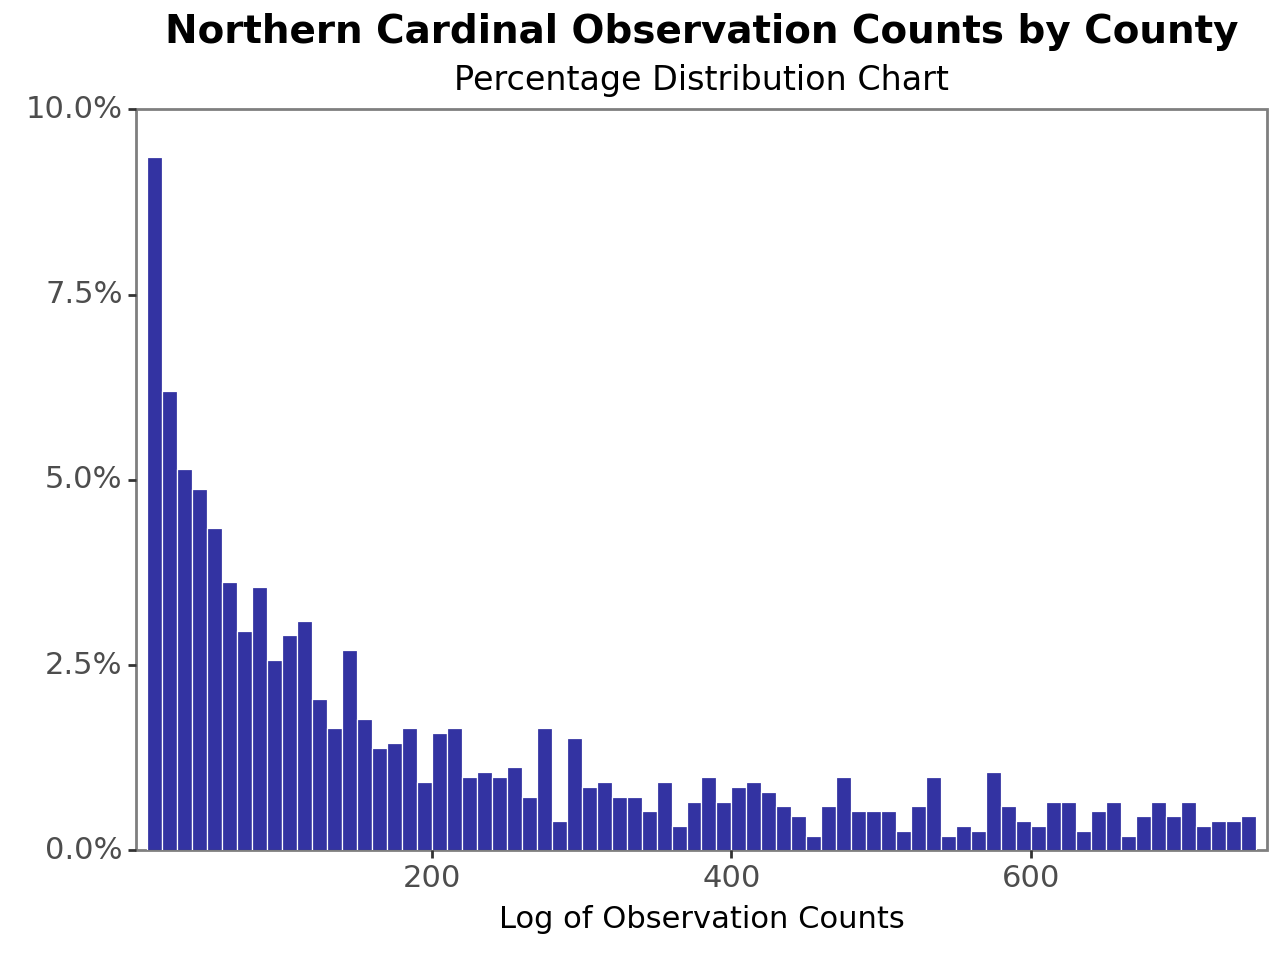


OBSERVATION COUNT DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.53, pvalue=0.00
Skewness: 3.61
Kurtosis: 15.06

_______________________________________________________________________________________________




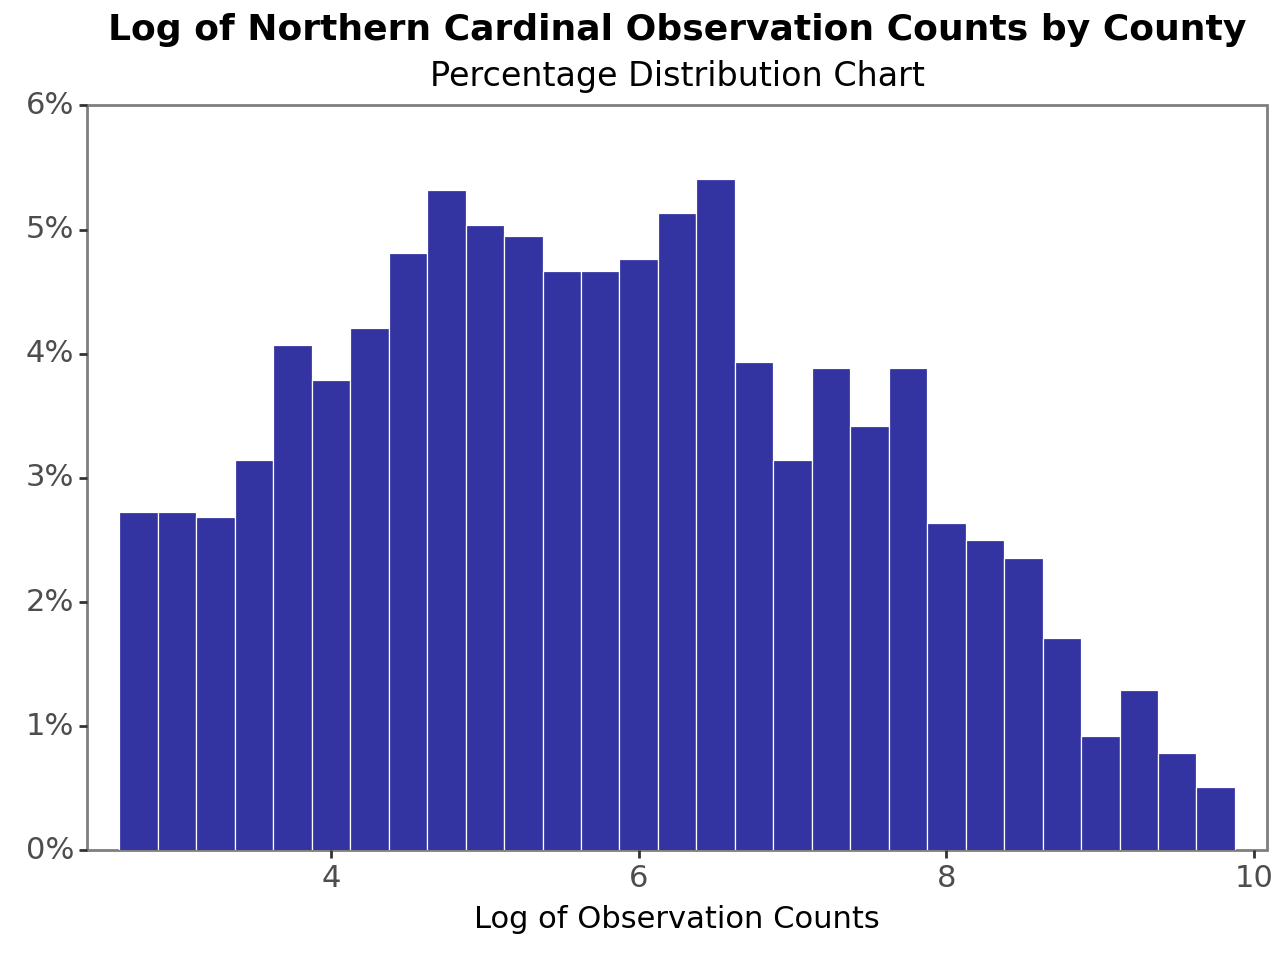


LOG OBSERVATION COUNT DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.98, pvalue=0.00
Skewness: 0.14
Kurtosis: -0.79


In [815]:
# non-transformed distribution chart
plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="OBSERVATION_COUNT", y="stat(count)/sum(stat(count))")) +
    geom_histogram(
        binwidth=10,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    ) +
    labs(title='Northern Cardinal Observation Counts by County',
         subtitle = "Percentage Distribution Chart",
         x="Log of Observation Counts", 
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(10, 750)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.1) 

)


# log transformed distribution chart
plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x='ln_OBSERVATION_COUNT')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=0.25,  # Adjust the binwidth as needed
        color="white",
        fill="darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title='Log of Northern Cardinal Observation Counts by County',
         subtitle = "Percentage Distribution Chart",
         x="Log of Observation Counts", 
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(2.5, 10)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=13, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.06) 
)



print(plot1)
print("OBSERVATION COUNT DISTRIBUTION STATS\n" + "-"*46)
normality_test('OBSERVATION_COUNT')
print("\n" + "_"*95 + "\n\n")
print(plot2)
print("LOG OBSERVATION COUNT DISTRIBUTION STATS\n" + "-"*46)
normality_test('ln_OBSERVATION_COUNT')

### `DURATION_MINUTES` Distribution with Log Transformation Comparison

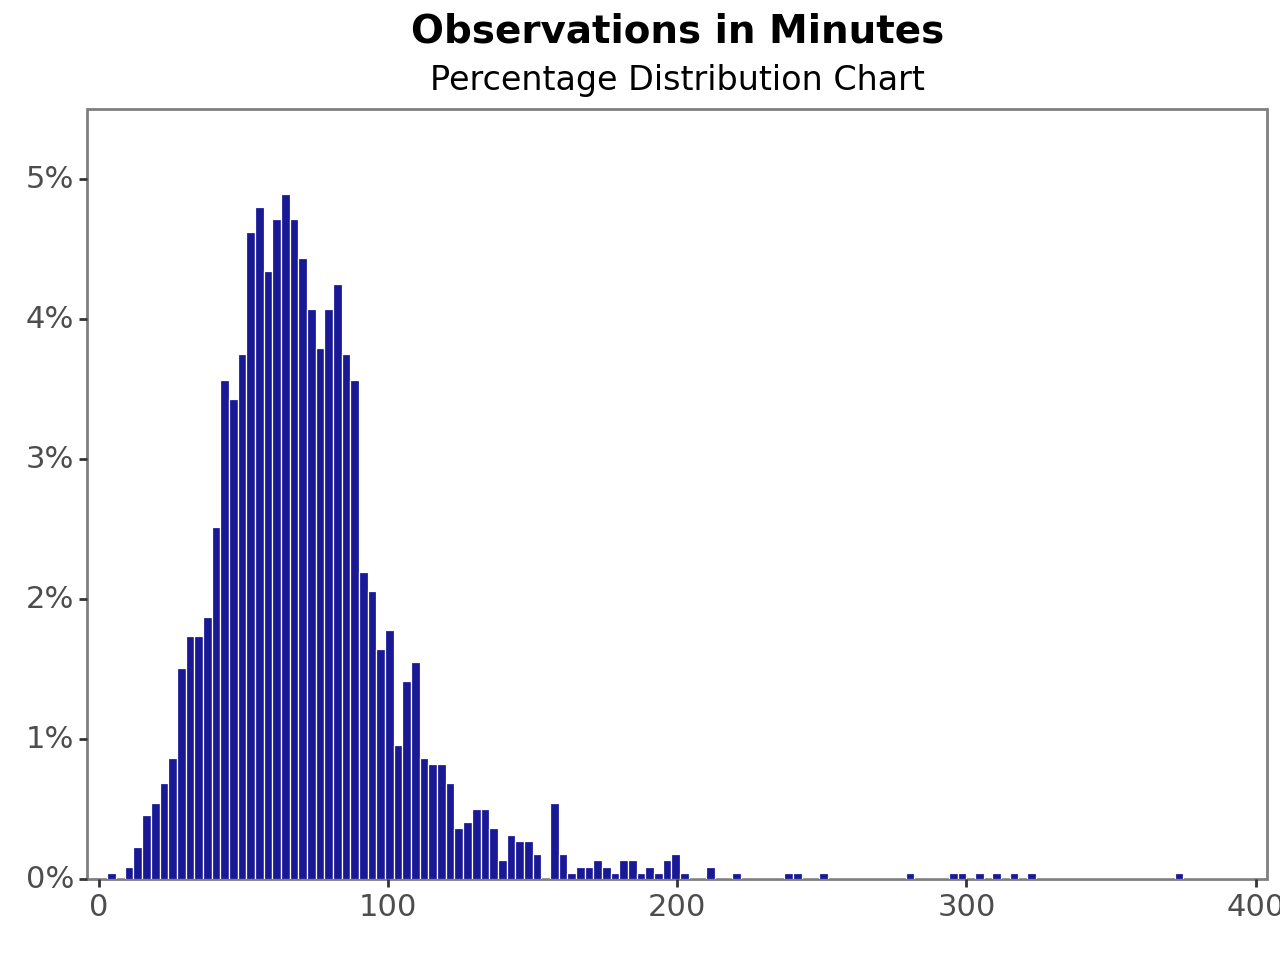


DURATION IN MINUTES DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.75, pvalue=0.00
Skewness: 4.19
Kurtosis: 40.27

_______________________________________________________________________________________________




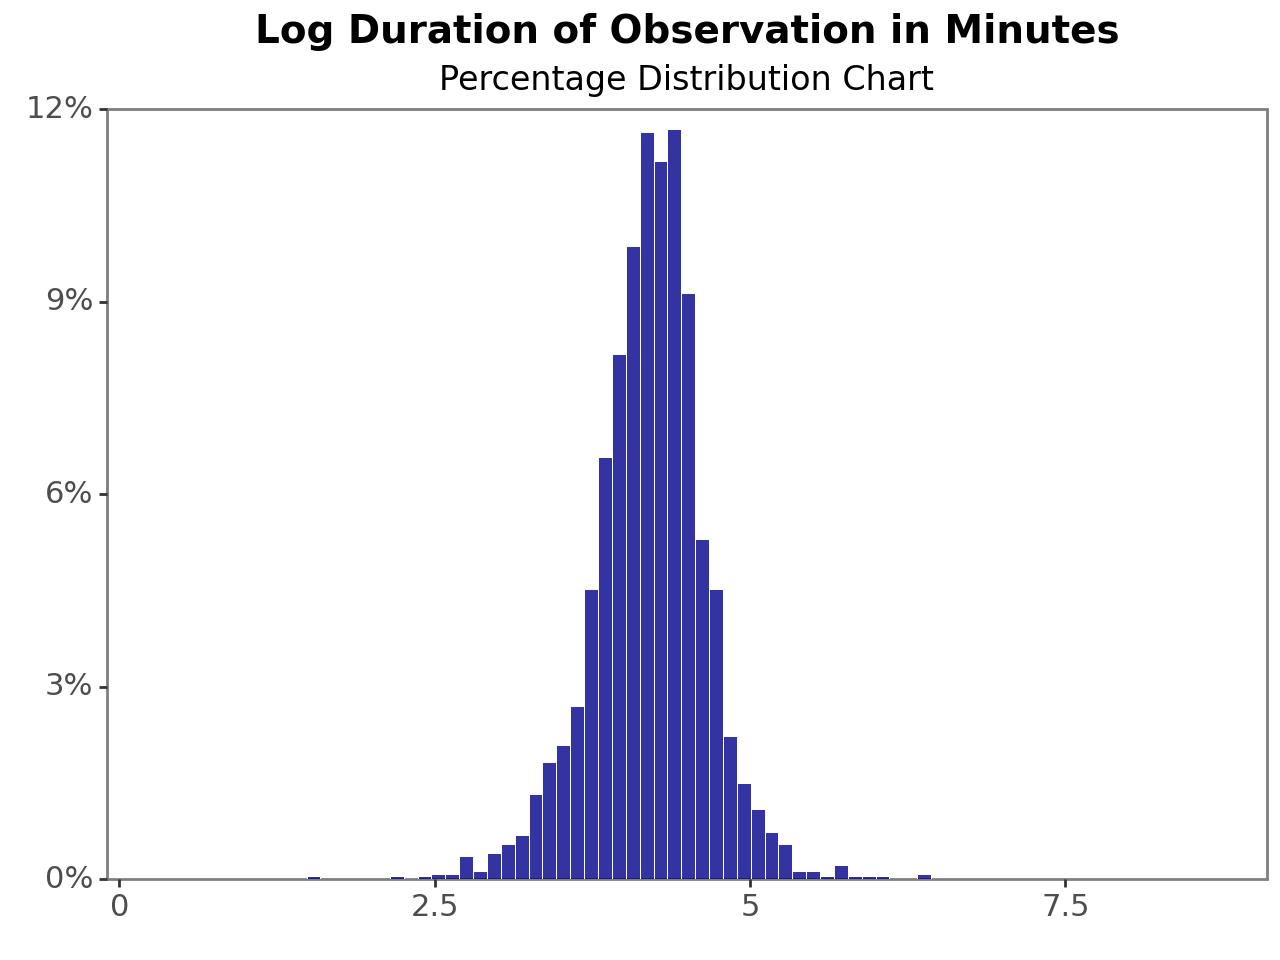


LOG OBSERVATIONS DURATION IN MINUTES DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.98, pvalue=0.00
Skewness: -0.23
Kurtosis: 2.24


In [805]:
plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="DURATION_MINUTES", y="stat(count)/sum(stat(count))")) +
    geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.9,
        show_legend=False,
        na_rm=True,
    ) +
    labs(title = "Observations in Minutes",
         subtitle = "Percentage Distribution Chart",
           x="",
           y=""
    ) +
    expand_limits(x=0.01, y=0.01) +
    scale_x_continuous(expand=(0.01, 0.01), limits=(0, 400)) +
    scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.055),
        expand=(0.0, 0.0),
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    )
)



plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x='ln_DURATION_MINUTES')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=0.11,  # Adjust the binwidth as needed
        color="white",
        fill = "darkblue",
        size=0.2,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title = "Log Duration of Observation in Minutes",
         subtitle = "Percentage Distribution Chart",
         x="",
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(0, 9)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.12)  # Ensure that the y-axis includes up to 12
)


print(plot1)
print("DURATION IN MINUTES DISTRIBUTION STATS\n" + "-"*46)
normality_test('DURATION_MINUTES')
print("\n" + "_"*95 + "\n\n")
print(plot2)
print("LOG OBSERVATIONS DURATION IN MINUTES DISTRIBUTION STATS\n" + "-"*46)
normality_test('ln_DURATION_MINUTES')

### `EFFORT_DISTANCE` Distribution with Log Transformation Comparison

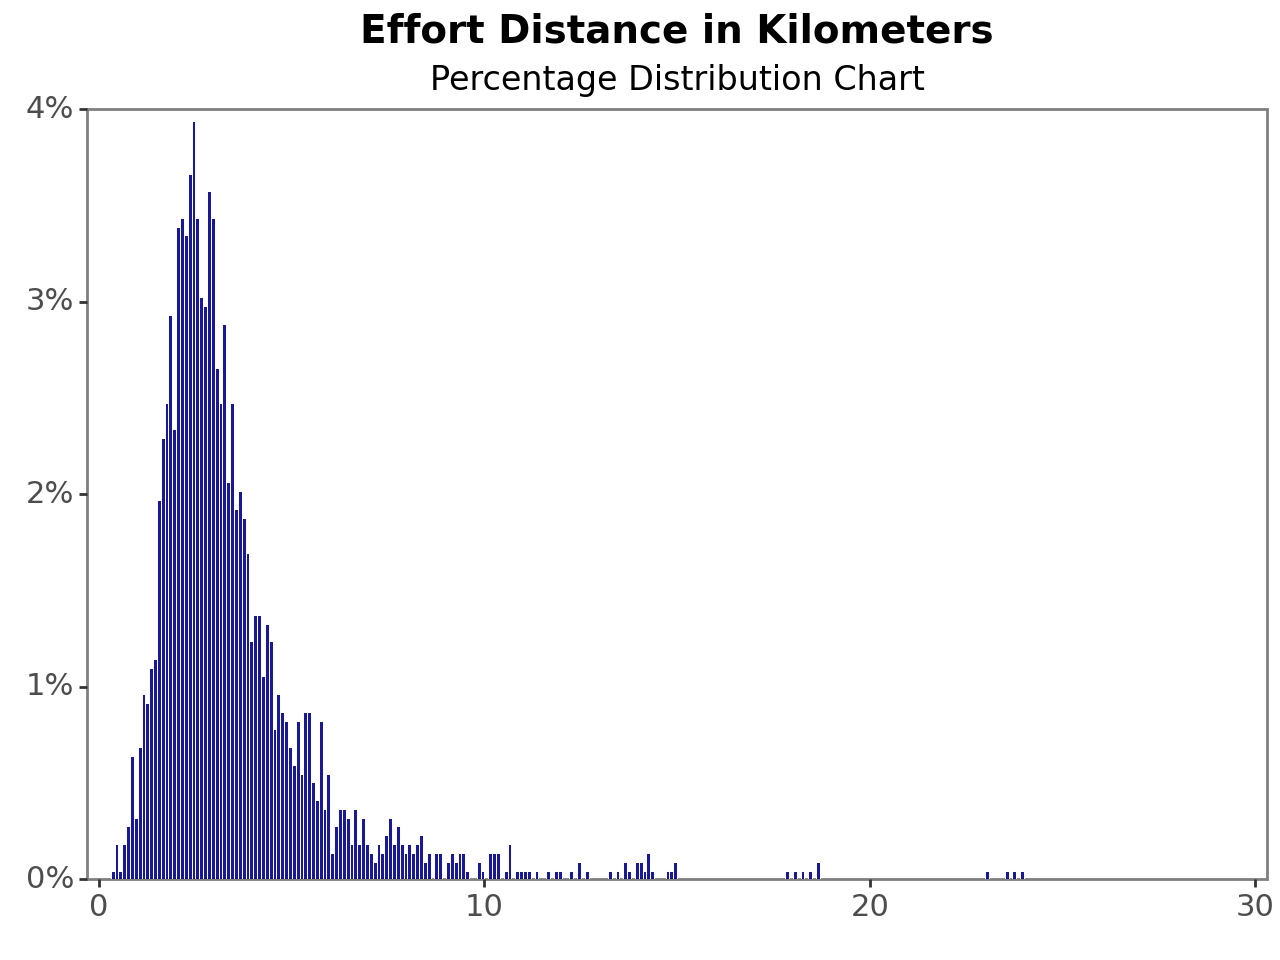


EFFORT DISTANCE IN KM DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.55, pvalue=0.00
Skewness: 9.83
Kurtosis: 207.51

_______________________________________________________________________________________________




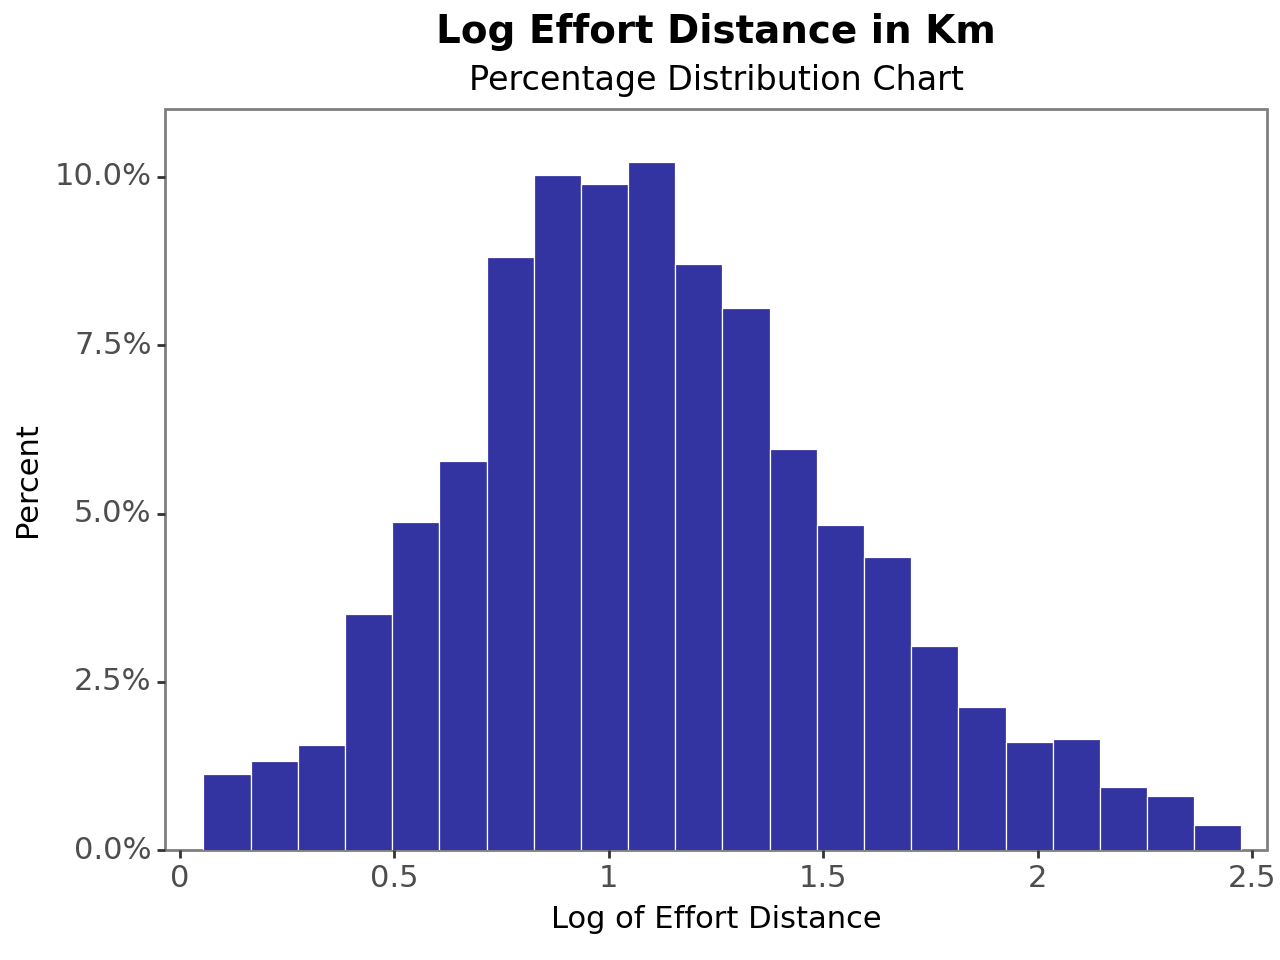


LOG EFFORT DISTANCE IN KM DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.98, pvalue=0.00
Skewness: 0.44
Kurtosis: 1.76


In [812]:
plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="EFFORT_DISTANCE_KM", y="stat(count)/sum(stat(count))")) +
    geom_histogram(
        binwidth=.1, # cannot be higher than .1
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.2,
        alpha=.9,
        show_legend=False,
        na_rm=True,
    ) +
    labs(title = "Effort Distance in Kilometers",
         subtitle = "Percentage Distribution Chart",
           x="",
           y="") +
    expand_limits(x=0.01, y=0.01) +
    scale_x_continuous(expand=(0.01, 0.01), limits=(0, 30)) +
    scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.04),
        expand=(0.0, 0.0),
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    )
    
)

plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x='ln_EFFORT_DISTANCE_KM')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=0.11,  # Adjust the binwidth as needed
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title = "Log Effort Distance in Km",
         subtitle = "Percentage Distribution Chart",
         x="Log of Effort Distance", 
         y="Percent") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(0, 2.5)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(x=0.01, y=0.11) 
)

print(plot1)
print("EFFORT DISTANCE IN KM DISTRIBUTION STATS\n" + "-"*46)
normality_test('EFFORT_DISTANCE_KM')

print("\n" + "_"*95 + "\n\n")
print(plot2)
print("LOG EFFORT DISTANCE IN KM DISTRIBUTION STATS\n" + "-"*46)
normality_test('ln_EFFORT_DISTANCE_KM')

### `R_NATURAL_CHG_2022` Distribution 

A histogram was created for this visualization, along with the distribution statistics test. 

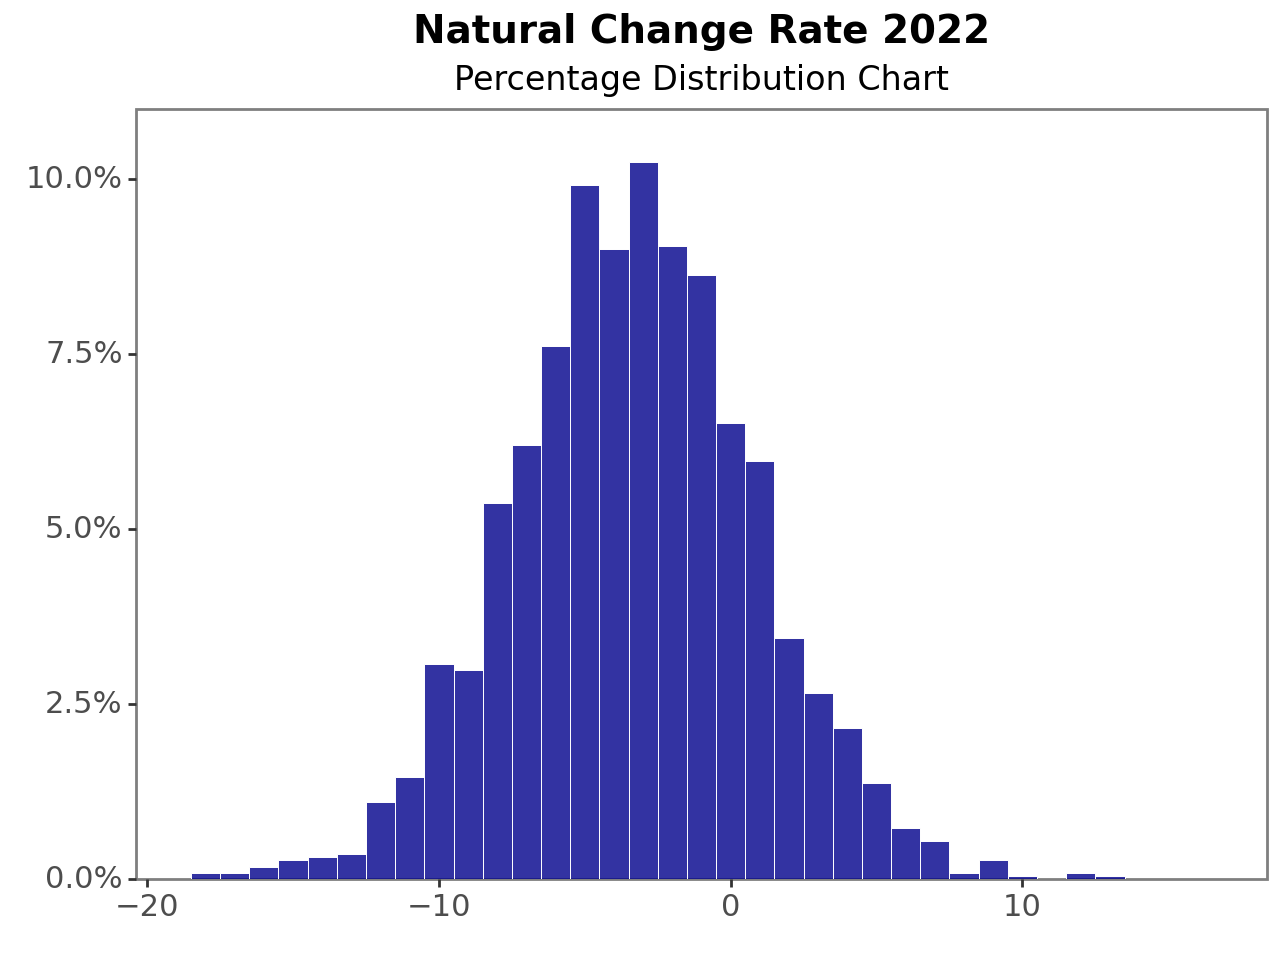


NATURAL CHANGE RATE 2022 DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.99, pvalue=0.00
Skewness: 0.04
Kurtosis: 1.16


In [817]:
plot = (
    ggplot(county_norcar_merged_dummies, aes(x='R_NATURAL_CHG_2022')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=1,  # Adjust the binwidth as needed
        color="white",
        fill = "darkblue",
        size=0.2,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title = "Natural Change Rate 2022",
         subtitle = "Percentage Distribution Chart",
         x="",
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(-20, 18)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.11)  # Ensure that the y-axis includes up to 12
)


print(plot)
print("NATURAL CHANGE RATE 2022 DISTRIBUTION STATS\n" + "-"*46)
normality_test('R_NATURAL_CHG_2022')


### `R_NET_MIG_2022` Distribution 

A histogram was created for this visualization, along with the distribution statistics test. 

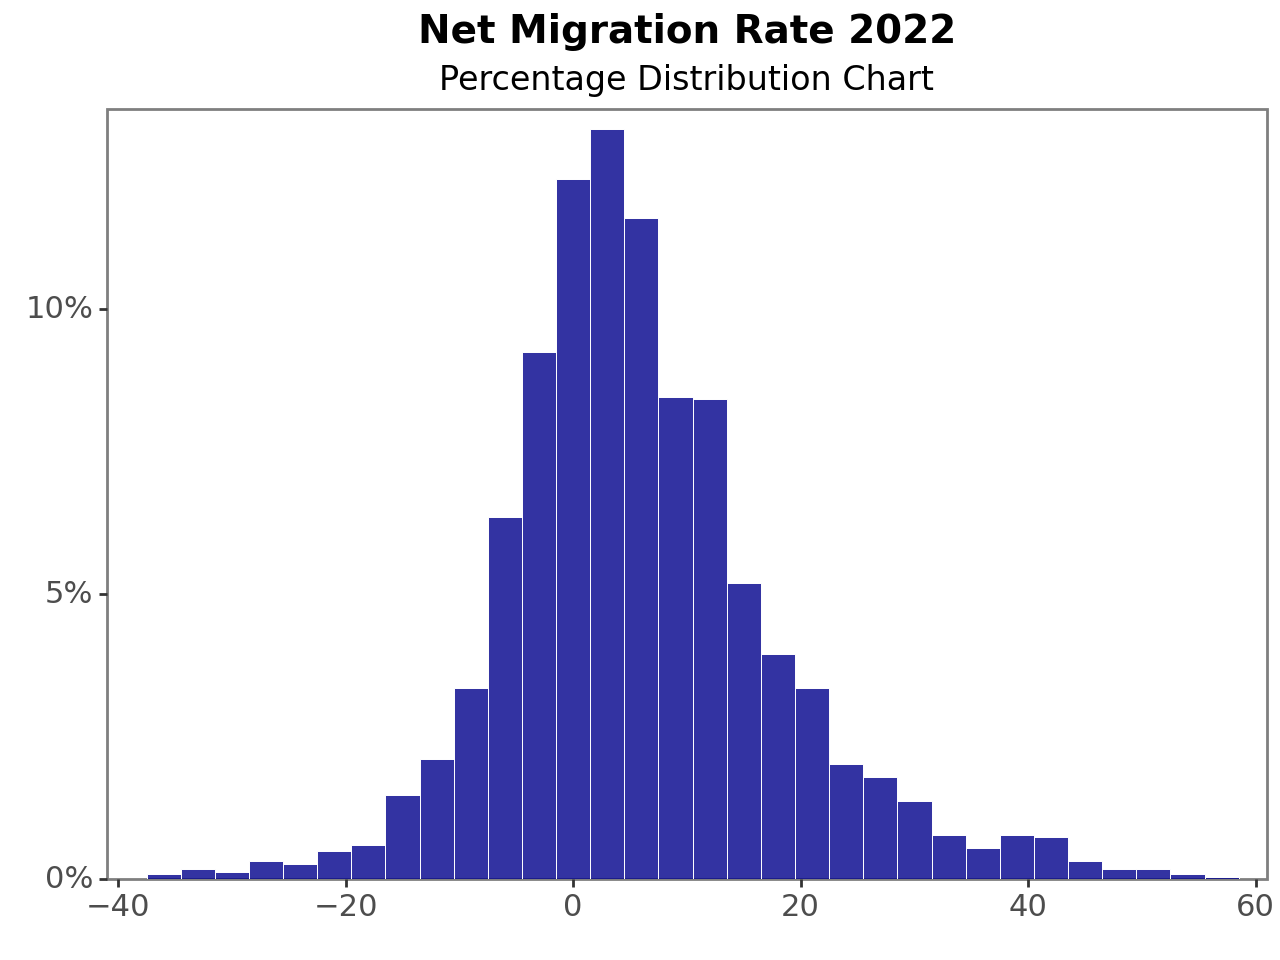


NET MIGRATION RATE 2022 DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.95, pvalue=0.00
Skewness: 0.79
Kurtosis: 3.05


In [818]:
plot = (
    ggplot(county_norcar_merged_dummies, aes(x='R_NET_MIG_2022')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=3,  # Adjust the binwidth as needed
        color="white",
        fill = "darkblue",
        size=0.2,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title = "Net Migration Rate 2022",
         subtitle = "Percentage Distribution Chart",
         x="",
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(-40, 60)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.135)  # Ensure that the y-axis includes up to 12
)

print(plot)
print("NET MIGRATION RATE 2022 DISTRIBUTION STATS\n" + "-"*46)
normality_test('R_NET_MIG_2022')


### `Urban_Influence_2013` County Percentage Distribution 

A barchart was created for this county percentage distribution. 

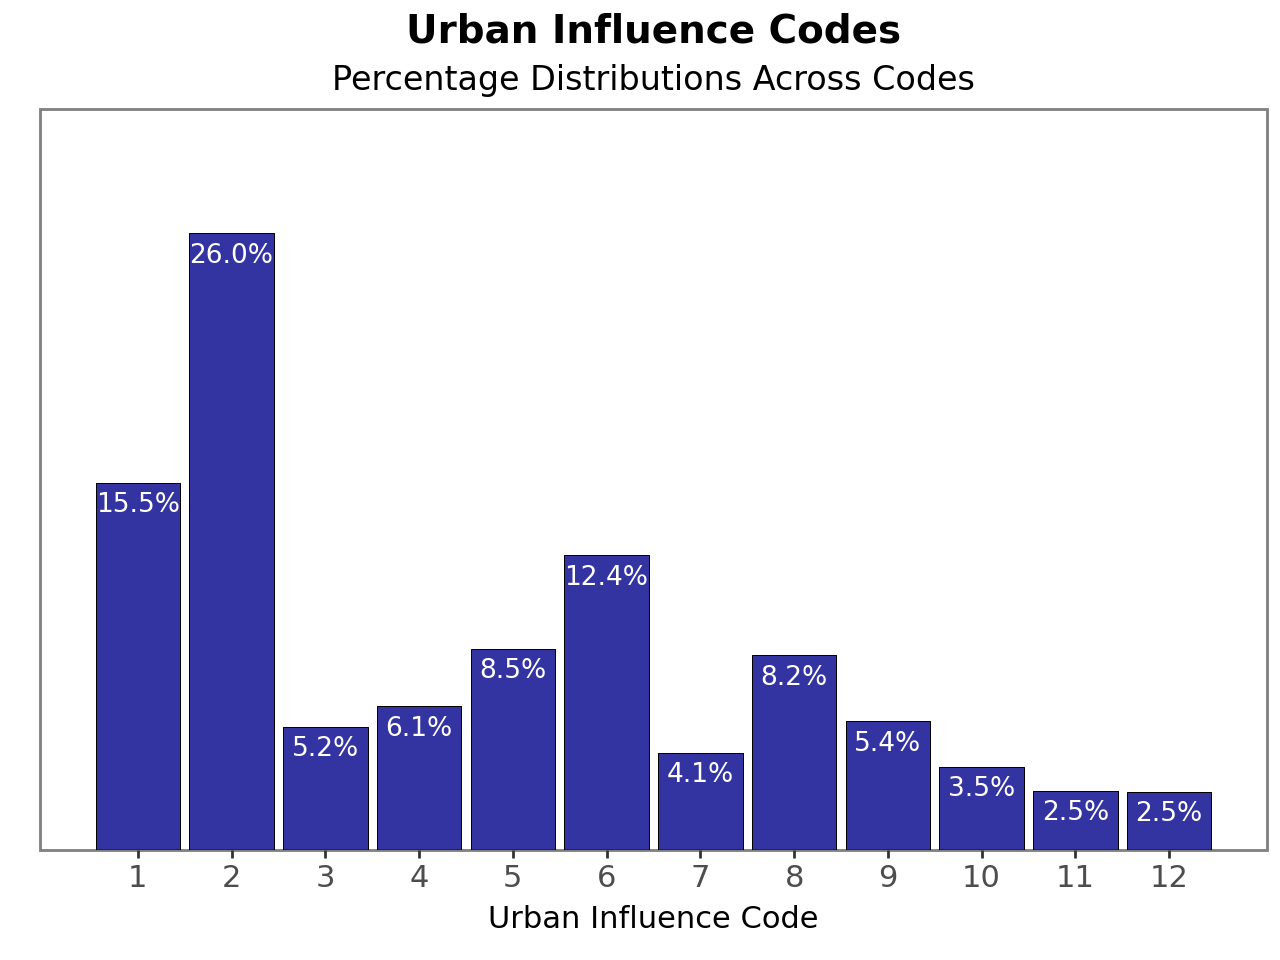

In [755]:
counts = county_norcar_merged_dummies['Urban_Influence_2013'].value_counts(normalize=True) # Get the percentage of each category
counts_df = counts.reset_index().rename(columns={'index': 'index', 'Urban_Influence_2013': 'Urban_Influence_2013', 'proportion':'Percentage'})

plot = (
    ggplot(counts_df, aes(x='Urban_Influence_2013', y='Percentage')) +
    geom_bar(stat='identity', fill='darkblue', color='black', size=0.2, alpha=0.8) +
    geom_text(
        aes(label='round(Percentage * 100, 1)'),  # Round the percentage to 1 decimal places
        stat='identity',
        nudge_y=-.015,
        va='bottom',
        size=9.5,
        color='white',
        format_string='{}%'
    ) +
    labs(title='Urban Influence Codes',
         subtitle = "Percentage Distributions Across Codes",
         x='Urban Influence Code',
         y='') +
    theme_bw() +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0), limits=(0, 1.2 * max(counts_df['Percentage']))) +  # Expand y-axis range
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        axis_text_y=element_blank(),  # Remove y-axis labels
        axis_ticks_major_y=element_blank(),  # Remove y-axis ticks
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks_minor=element_blank()
    )
)

print(plot)


### `Rural_Urban_Continuum_Code_2013` County Percentage Distribution 

A barchart was created for this county percentage distribution. 

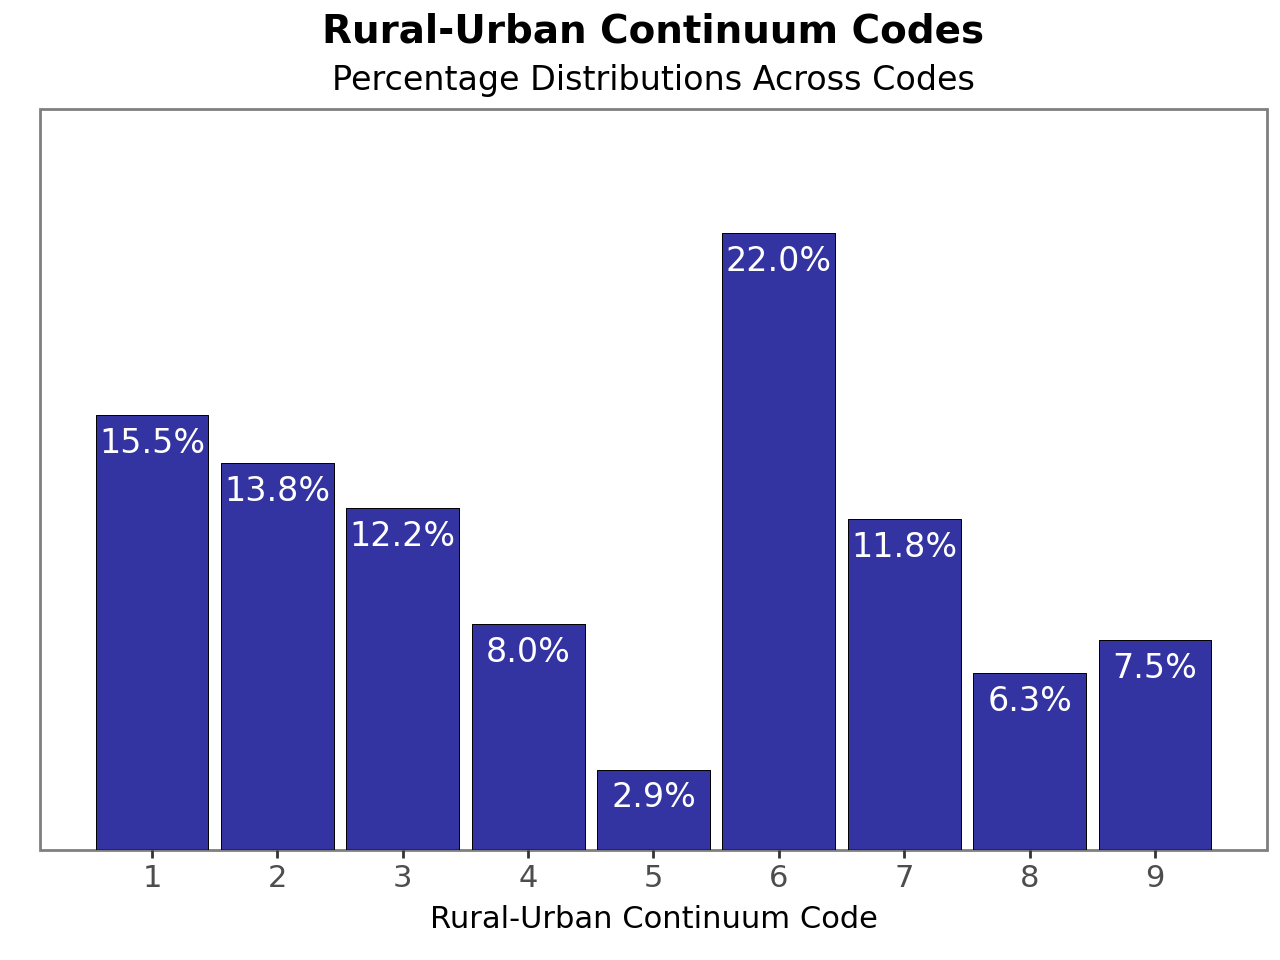

In [762]:
counts = county_norcar_merged_dummies['Rural_Urban_Continuum_Code_2013'].value_counts(normalize=True) # Get the percentage of each category
counts_df = counts.reset_index().rename(columns={'index': 'index', 'Rural_Urban_Continuum_Code_2013': 'Rural_Urban_Continuum_Code_2013', 'proportion':'Percentage'})

plot = (
    ggplot(counts_df, aes(x='Rural_Urban_Continuum_Code_2013', y='Percentage')) +
    geom_bar(stat='identity', fill='darkblue', color='black', size=0.2, alpha=0.8) +
    geom_text(
        aes(label='round(Percentage * 100, 1)'),  # Round the percentage to 1 decimal places
        stat='identity',
        nudge_y=-.016,
        va='bottom',
        size=12,
        color='white',
        format_string='{}%'
    ) +
    labs(title='Rural-Urban Continuum Codes',
         subtitle = "Percentage Distributions Across Codes",
         x='Rural-Urban Continuum Code',
         y='') +
    theme_bw() +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0), limits=(0, 1.2 * max(counts_df['Percentage']))) +  # Expand y-axis range
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        axis_text_y=element_blank(),  # Remove y-axis labels
        axis_ticks_major_y=element_blank(),  # Remove y-axis ticks
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks_minor=element_blank()
    )
)

# Display the plot
print(plot)


### `Economic_typology_2015` County Percentage Distribution 

A barchart was created for this county percentage distribution. 

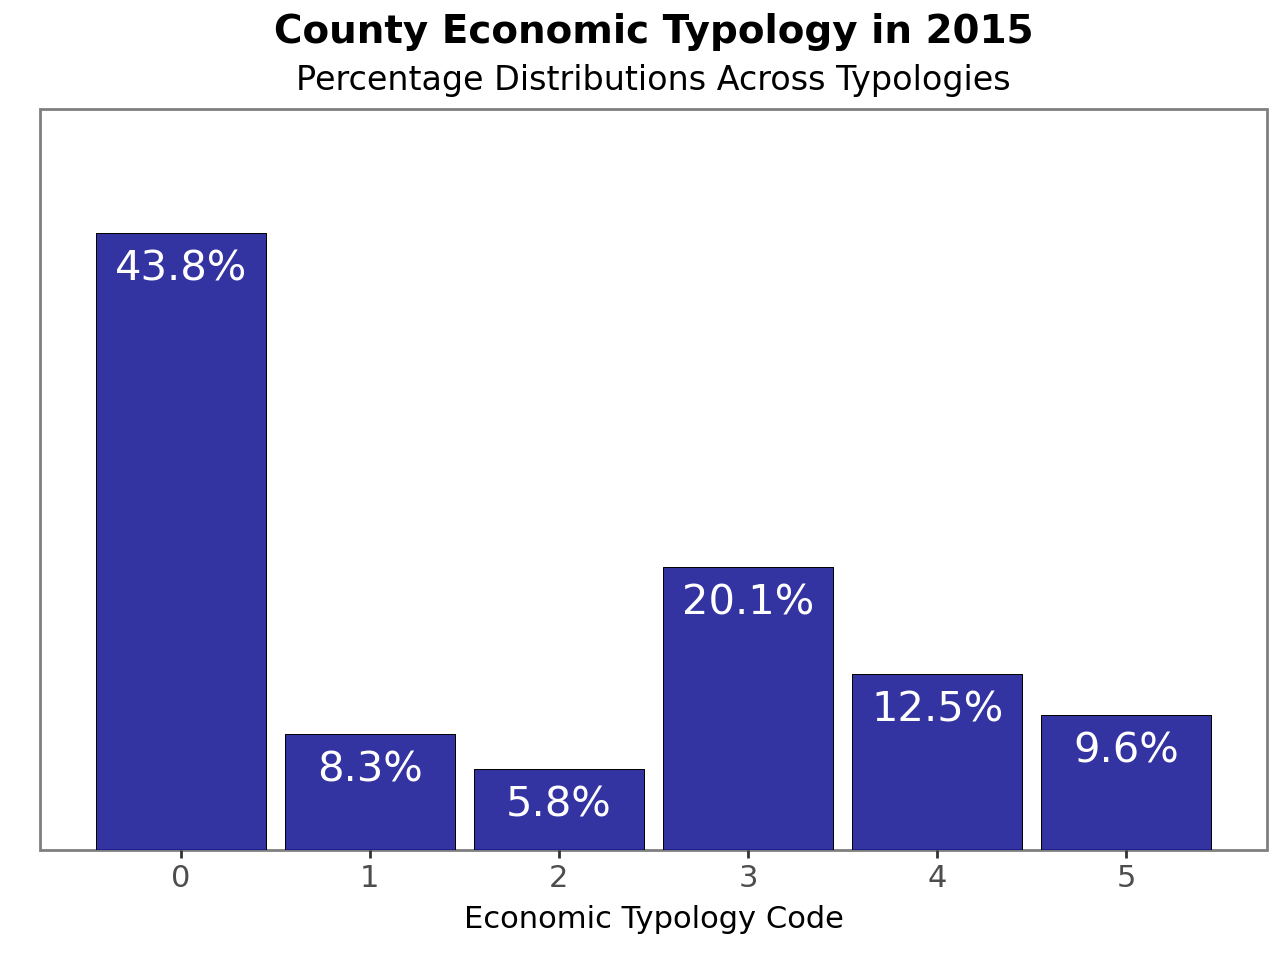

In [765]:
counts = county_norcar_merged_dummies['Economic_typology_2015'].value_counts(normalize=True) # Get the percentage of each category
counts_df = counts.reset_index().rename(columns={'index': 'index', 'Economic_typology_2015': 'Economic_typology_2015', 'proportion':'Percentage'})

plot = (
    ggplot(counts_df, aes(x='Economic_typology_2015', y='Percentage')) +
    geom_bar(stat='identity', fill='darkblue', color='black', size=0.2, alpha=0.8) +
    geom_text(
        aes(label='round(Percentage * 100, 1)'),  # Round the percentage to 1 decimal places
        stat='identity',
        nudge_y=-.04,
        va='bottom',
        size=15,
        color='white',
        format_string='{}%'
    ) +
    labs(title='County Economic Typology in 2015',
         subtitle = "Percentage Distributions Across Typologies",
         x='Economic Typology Code',
         y='') +
    theme_bw() +
    scale_x_continuous(breaks=range(0, 6)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0), limits=(0, 1.2 * max(counts_df['Percentage']))) +  # Expand y-axis range
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        axis_text_y=element_blank(),  # Remove y-axis labels
        axis_ticks_major_y=element_blank(),  # Remove y-axis ticks
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks_minor=element_blank()
    )
)

# Display the plot
print(plot)


# Regression Analyses and Predictive Models

## OLS Regression Models of `Urban_Influence_2013` on `ln_OBSERVATION_COUNT`

In [624]:
# OLS on Urban Influence Codes
reg1 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2", data=county_norcar_merged_dummies).fit(cov_type="HC1") #unconditional
reg2 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg3 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg4 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg5 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg6 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg7 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg8 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8 + UrbanInfluence_9", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg9 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8 + UrbanInfluence_9 + UrbanInfluence_10", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg10 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8 + UrbanInfluence_9 + UrbanInfluence_10 + UrbanInfluence_11", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg11 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8 + UrbanInfluence_9 + UrbanInfluence_10 + UrbanInfluence_11 + UrbanInfluence_12", data=county_norcar_merged_dummies).fit(cov_type="HC1")


stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8, reg9, reg10, reg11])
stargazer.covariate_order(["UrbanInfluence_2", "UrbanInfluence_3", "UrbanInfluence_4", 
                           "UrbanInfluence_5", "UrbanInfluence_6", "UrbanInfluence_7", 
                           "UrbanInfluence_8", "UrbanInfluence_9", "UrbanInfluence_10",
                           "UrbanInfluence_11", "UrbanInfluence_12", "Intercept"])

stargazer.rename_covariates({
    "UrbanInfluence_2": "Urban Influence Code 2",
    "UrbanInfluence_3": "Urban Influence Code 3",
    "UrbanInfluence_4": "Urban Influence Code 4",
    "UrbanInfluence_5": "Urban Influence Code 5",
    "UrbanInfluence_6": "Urban Influence Code 6",
    "UrbanInfluence_7": "Urban Influence Code 7",
    "UrbanInfluence_8": "Urban Influence Code 8",
    "UrbanInfluence_9": "Urban Influence Code 9",
    "UrbanInfluence_10": "Urban Influence Code 10",
    "UrbanInfluence_11": "Urban Influence Code 11",
    "UrbanInfluence_12": "Urban Influence Code 12",
    "Intercept": "Constant"
})
#stargazer.custom_columns(["Unconditional", "Level of Education", "BA Degree Quadratic", "MA & Prof Degree", "4th Order Polynomial"], [1, 1, 1, 1, 1])
stargazer

### Predictive Model from the OLS Regression of `Urban_Influence_2013` on `ln_OBSERVATION_COUNT`

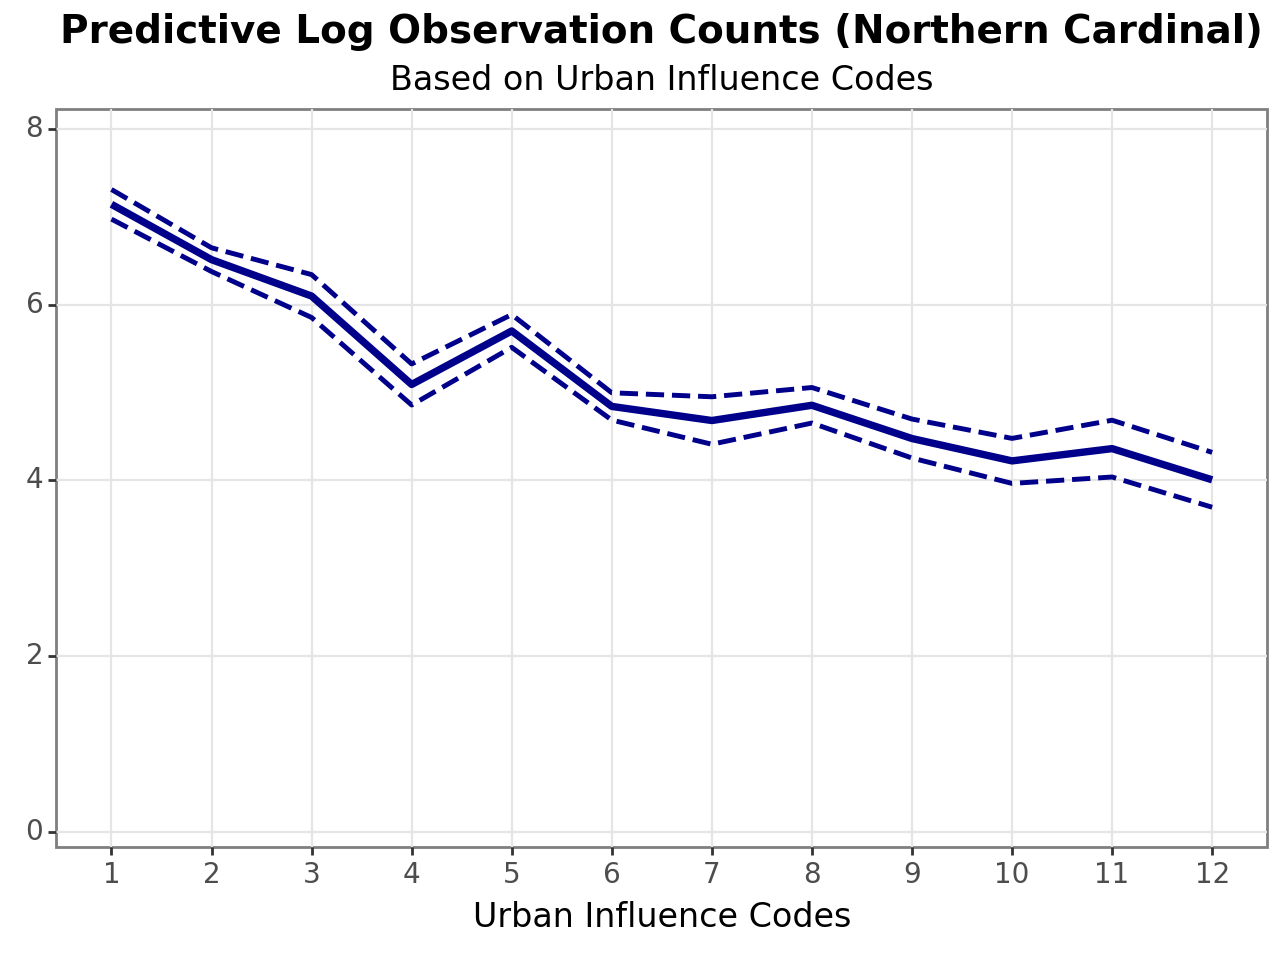

In [819]:
# Use the regression model to predict 'OBSERVATION_COUNT'
pred = reg11.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

# Plotting the predictions along with their confidence intervals
plot = (
    ggplot(county_norcar_merged_dummies, aes(x="Urban_Influence_2013", y="fit")) +
    geom_line(color="darkblue", size=1.5) +  # Main line for fit values
    geom_line(aes(y="CIup"), linetype="dashed", color="darkblue", size=1) +  # Upper confidence interval
    geom_line(aes(y="CIlo"), linetype="dashed", color="darkblue", size=1) +  # Lower confidence interval
    labs(
        title="Predictive Log Observation Counts (Northern Cardinal)",
        subtitle="Based on Urban Influence Codes",
        x="Urban Influence Codes",
        y=""
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_title=element_text(size=12),
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        legend_position="bottom",
        panel_grid_minor=element_blank(),
    ) +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].max() * 1.1),  # Add a 10% buffer to the max limit for visual appeal
        expand=(0.02, 0.02)  # Small expansion factor for padding
    ) +
    guides(color=guide_legend(title="Legend"))  # Add and customize legend
)

# Display the plot
print(plot)


## OLS Regression Models of `Rural_Urban_Continuum_Code_2013` on `ln_OBSERVATION_COUNT`

In [820]:
# OLS on Rural-Urban Continuum Codes
reg12 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2", data=county_norcar_merged_dummies).fit(cov_type="HC1") # Unconditional
reg13 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg14 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg15 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg16 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5 + Continuum_6", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg17 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5 + Continuum_6 + Continuum_7", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg18 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5 + Continuum_6 + Continuum_7 + Continuum_8", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg19 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5 + Continuum_6 + Continuum_7 + Continuum_8 + Continuum_9", data=county_norcar_merged_dummies).fit(cov_type="HC1")

stargazer = Stargazer([reg12, reg13, reg14, reg15, reg16, reg17, reg18, reg19])
stargazer.covariate_order(["Continuum_2", "Continuum_3", "Continuum_4", 
                           "Continuum_5", "Continuum_6", "Continuum_7", 
                           "Continuum_8", "Continuum_9", "Intercept"])

stargazer.rename_covariates({
    "Continuum_2": "Rural-Urban Continuum Code 2",
    "Continuum_3": "Rural-Urban Continuum Code 3",
    "Continuum_4": "Rural-Urban Continuum Code 4",
    "Continuum_5": "Rural-Urban Continuum Code 5",
    "Continuum_6": "Rural-Urban Continuum Code 6",
    "Continuum_7": "Rural-Urban Continuum Code 7",
    "Continuum_8": "Rural-Urban Continuum Code 8",
    "Continuum_9": "Rural-Urban Continuum Code 9",
    "Intercept": "Constant"
})

#stargazer.custom_columns(["Unconditional", "Level of Education", "BA Degree Quadratic", "MA & Prof Degree", "4th Order Polynomial"], [1, 1, 1, 1, 1])
stargazer

### Predictive Model from the OLS Regression of `Rural_Urban_Continuum_Code_2013` on `ln_OBSERVATION_COUNT`

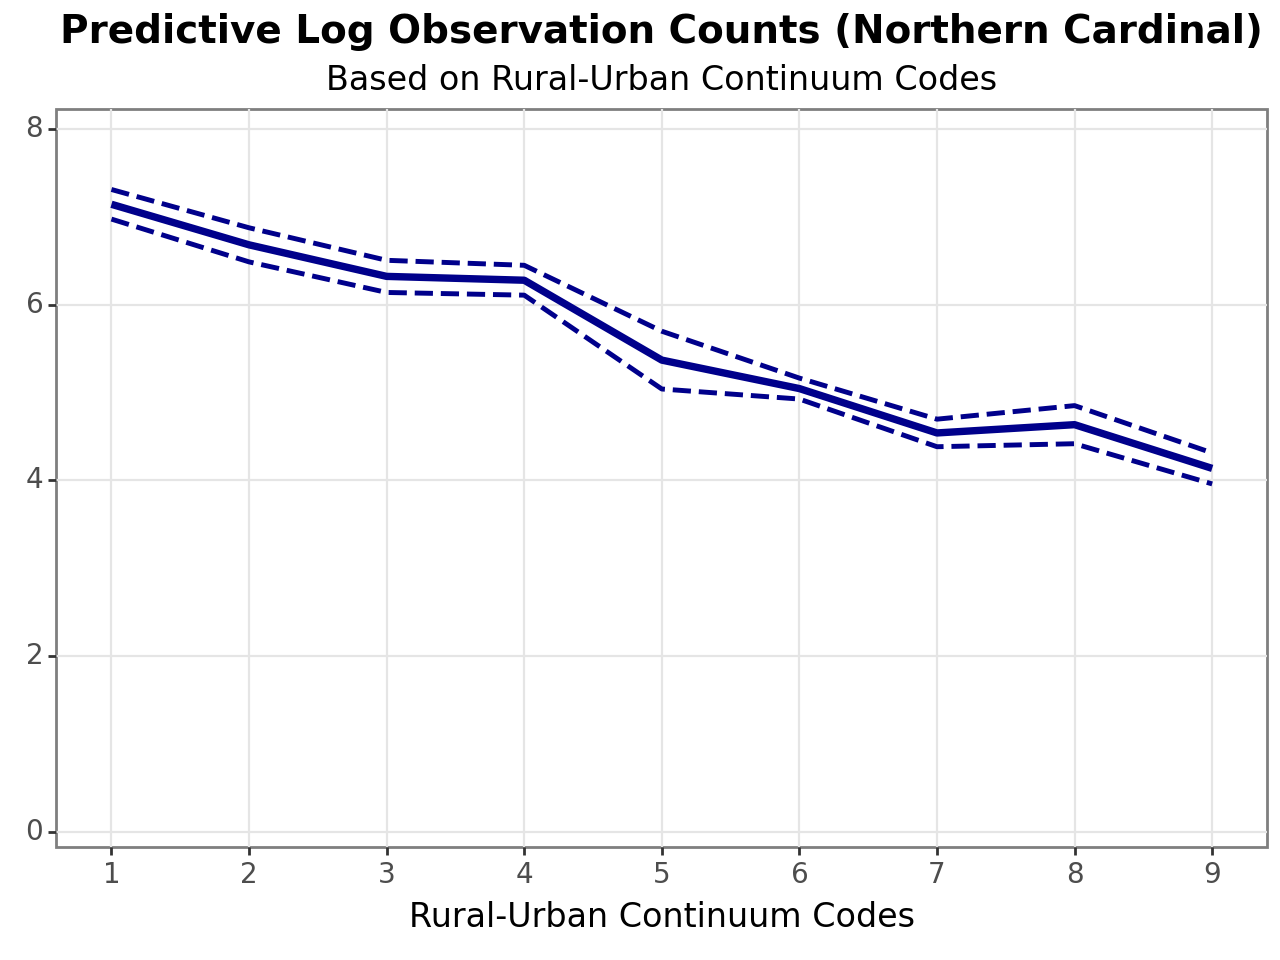

In [821]:
# Use the regression model to predict 'OBSERVATION_COUNT'
pred = reg19b.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

# Plotting the predictions along with their confidence intervals
plot = (
    ggplot(county_norcar_merged_dummies, aes(x="Rural_Urban_Continuum_Code_2013", y="fit")) +
    geom_line(color="darkblue", size=1.5) +  # Main line for fit values
    geom_line(aes(y="CIup"), linetype="dashed", color="darkblue", size=1) +  # Upper confidence interval
    geom_line(aes(y="CIlo"), linetype="dashed", color="darkblue", size=1) +  # Lower confidence interval
    labs(
        title="Predictive Log Observation Counts (Northern Cardinal)",
        subtitle="Based on Rural-Urban Continuum Codes",
        x="Rural-Urban Continuum Codes",
        y=""
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_title=element_text(size=12),
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        legend_position="bottom",
        panel_grid_minor=element_blank(),
    ) +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].max() * 1.1),  # Add a 10% buffer to the max limit for visual appeal
        expand=(0.02, 0.02)  # Small expansion factor for padding
    ) +
    guides(color=guide_legend(title="Legend"))  # Add and customize legend
)


print(plot)


## OLS Regression Models of `Economic_typology_2015` on `ln_OBSERVATION_COUNT`

In [822]:
# OLS on Rural-Urban Continuum Codes
reg20 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1") # Unconditional
reg21 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent + EconType_MiningDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg22 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent + EconType_MiningDependent + EconType_ManufacturingDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg23 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent + EconType_MiningDependent + EconType_ManufacturingDependent + EconType_FederalStateGovDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg24 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent + EconType_MiningDependent + EconType_ManufacturingDependent + EconType_FederalStateGovDependent + EconType_RecreationDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1")


stargazer = Stargazer([reg20, reg21, reg22, reg23, reg24])
stargazer.covariate_order(["EconType_FarmDependent", "EconType_MiningDependent", "EconType_ManufacturingDependent", 
                           "EconType_FederalStateGovDependent", "EconType_RecreationDependent", "Intercept"])

stargazer.rename_covariates({
    "EconType_FarmDependent": "Economically Farming Dependent",
    "EconType_MiningDependent": "Economically Mining Dependent",
    "EconType_ManufacturingDependent": "Economically Manufacturing Dependent",
    "EconType_FederalStateGovDependent": "Economically Federal/State Government Dependent",
    "EconType_RecreationDependent": "Economically Recreation Dependent",
    "Intercept": "Constant"
})


#stargazer.custom_columns(["Unconditional", "Level of Education", "BA Degree Quadratic", "MA & Prof Degree", "4th Order Polynomial"], [1, 1, 1, 1, 1])
stargazer

### Predictive Model from the OLS Regression of `Economic_typology_2015` on `ln_OBSERVATION_COUNT`

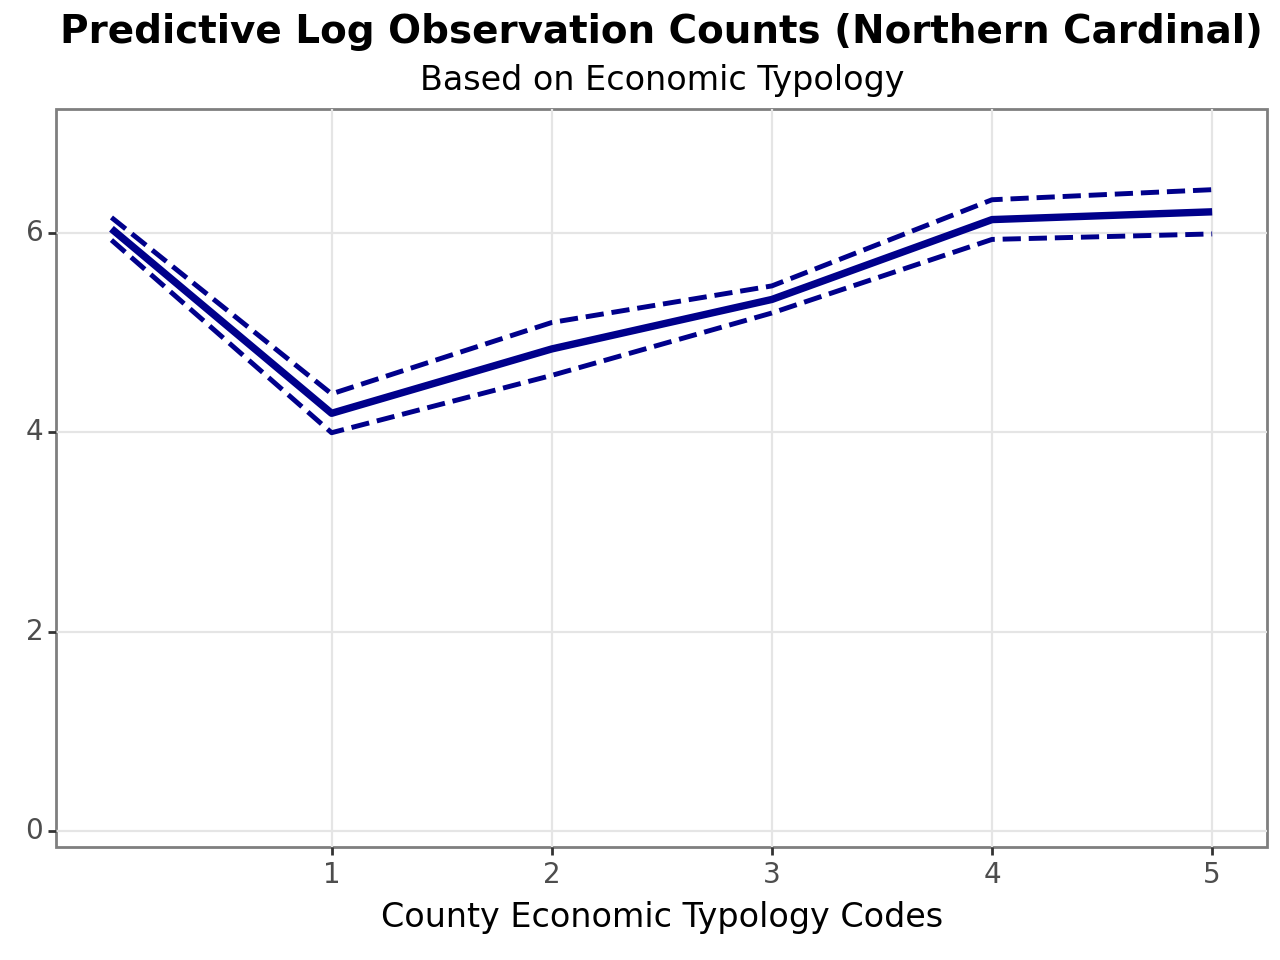

In [823]:
# Use the regression model to predict 'OBSERVATION_COUNT'
pred = reg24.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

# Plotting the predictions along with their confidence intervals

plot = (
    ggplot(county_norcar_merged_dummies, aes(x="Economic_typology_2015", y="fit")) +
    geom_line(color="darkblue", size=1.5) +  # Main line for fit values
    geom_line(aes(y="CIup"), linetype="dashed", color="darkblue", size=1) +  # Upper confidence interval
    geom_line(aes(y="CIlo"), linetype="dashed", color="darkblue", size=1) +  # Lower confidence interval
    labs(
        title="Predictive Log Observation Counts (Northern Cardinal)",
        subtitle="Based on Economic Typology",
        x="County Economic Typology Codes",
        y=""
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_title=element_text(size=12),
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        legend_position="bottom",
        panel_grid_minor=element_blank(),
    ) +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].max() * 1.1),  # Add a 10% buffer to the max limit for visual appeal
        expand=(0.02, 0.02)  # Small expansion factor for padding
    ) +
    guides(color=guide_legend(title="Legend"))  # Add and customize legend
)

print(plot)


## OLS Regression Models For `R_NATURAL_CHG_2022`, `R_NET_MIG_2022`, `ln_DURATION_MINUTES`, and `ln_EFFORT_DISTANCE_KM` on `ln_OBSERVATION_COUNT`

In [844]:
reg29 = smf.ols(formula="ln_OBSERVATION_COUNT ~ R_NATURAL_CHG_2022", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg30 = smf.ols(formula="ln_OBSERVATION_COUNT ~ R_NATURAL_CHG_2022 + R_NET_MIG_2022", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg31 = smf.ols(formula="ln_OBSERVATION_COUNT ~ ln_DURATION_MINUTES + ln_EFFORT_DISTANCE_KM", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg32 = smf.ols(formula="ln_OBSERVATION_COUNT ~ R_NATURAL_CHG_2022 + R_NET_MIG_2022 + ln_DURATION_MINUTES", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg33 = smf.ols(formula="ln_OBSERVATION_COUNT ~ R_NATURAL_CHG_2022 + R_NET_MIG_2022 + ln_DURATION_MINUTES + ln_EFFORT_DISTANCE_KM", data=county_norcar_merged_dummies).fit(cov_type="HC1")


stargazer = Stargazer([reg29, reg30, reg31, reg32, reg33])
stargazer.covariate_order(["R_NATURAL_CHG_2022", "R_NET_MIG_2022", "ln_DURATION_MINUTES", "ln_EFFORT_DISTANCE_KM", "Intercept"])

stargazer.rename_covariates({
    "R_NATURAL_CHG_2022": "Natural Change Rate 2022",
    "R_NET_MIG_2022" : "Net Migration Rate 2022",
    "ln_DURATION_MINUTES": "Log Duration of Observation",
    "ln_EFFORT_DISTANCE_KM" : "Log Distance Traveled for Observation",
    "Intercept": "Constant"
})

stargazer

### Predictive Models from the OLS Regression of `R_NATURAL_CHG_2022` and `R_NET_MIG_2022` on `ln_OBSERVATION_COUNT`

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning:

geom_jitter : Removed 99 rows containing missing values.



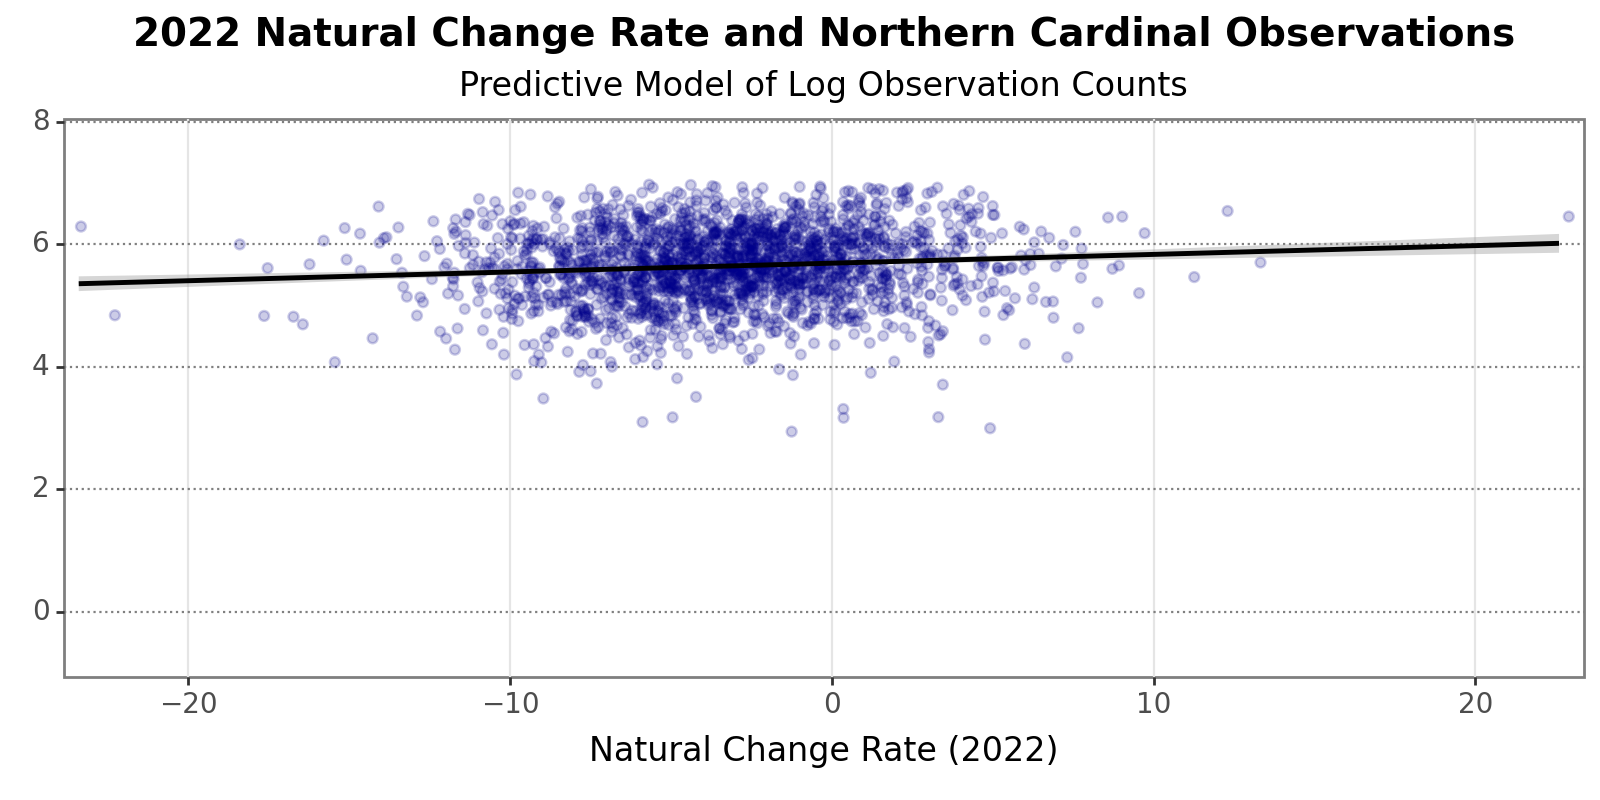



________________________________________________________________________________________________________________________




C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning:

geom_jitter : Removed 104 rows containing missing values.



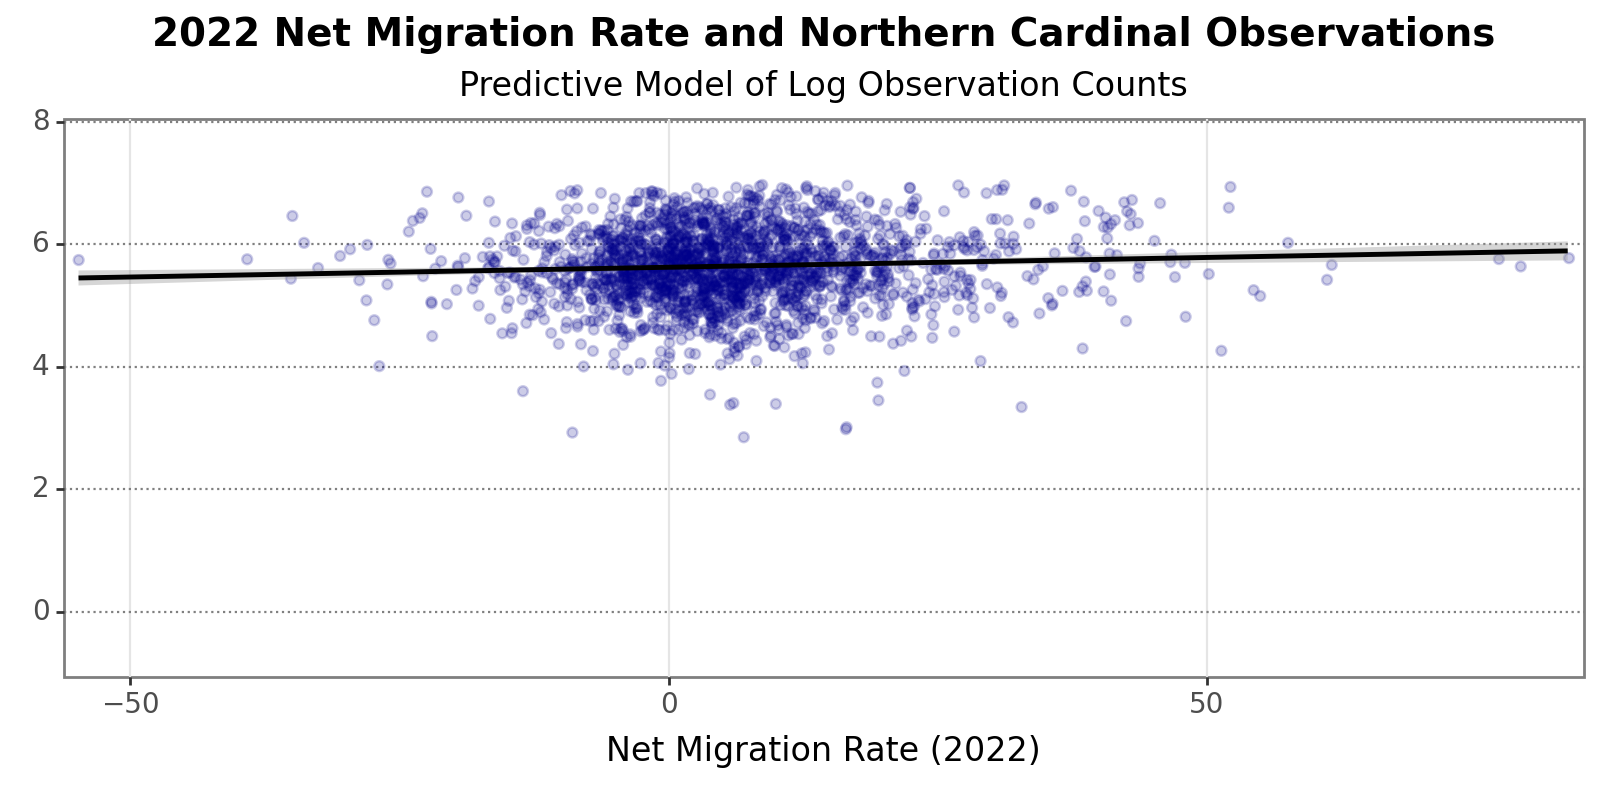

In [842]:
# Use the regression model to predict 'OBSERVATION_COUNT'
pred = reg30.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="R_NATURAL_CHG_2022", y="fit")) +
    geom_jitter(alpha=0.2, size=1.5, color='darkblue') +  # Muted green color
    geom_smooth(method='lm', color='black', se=True) +  # Smoothing line for regression
    labs(
        title="2022 Natural Change Rate and Northern Cardinal Observations",
        subtitle="Predictive Model of Log Observation Counts",
        x="Natural Change Rate (2022)",
        y=""
    ) +
    theme_bw(base_size=12) +  # Minimal theme with base font size
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        legend_position="none",  # Hide legend (if not necessary)
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_grid_major_y=element_line(color="grey", linetype="dotted"),  # Dotted major grid lines on y-axis
        figure_size=(8, 4)  # Aspect ratio of the plot, adjusted to your preference
    ) +
    scale_x_continuous(expand=(0.01, 0.01)) +  # Slight expansion for padding
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].quantile(0.95)),  # Limits for y-axis
        expand=(0.01, 1)  # Slight expansion for padding on y-axis
    )
)



plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x="R_NET_MIG_2022", y="fit")) +
    geom_jitter(alpha=0.2, size=1.5, color='darkblue') +  # Muted green color
    geom_smooth(method='lm', color='black', se=True) +  # Smoothing line for regression
    labs(
        title="2022 Net Migration Rate and Northern Cardinal Observations",
        subtitle="Predictive Model of Log Observation Counts",
        x="Net Migration Rate (2022)",
        y=""
    ) +
    theme_bw(base_size=12) +  # Minimal theme with base font size
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        legend_position="none",  # Hide legend (if not necessary)
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_grid_major_y=element_line(color="grey", linetype="dotted"),  # Dotted major grid lines on y-axis
        figure_size=(8, 4)  # Aspect ratio of the plot, adjusted to your preference
    ) +
    scale_x_continuous(expand=(0.01, 0.01)) +  # Slight expansion for padding
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].quantile(0.95)),  # Limits for y-axis
        expand=(0.01, 1)  # Slight expansion for padding on y-axis
    )
)

print(plot1)
print("\n" + "_"*120 + "\n\n")
print(plot2)


### Predictive Models from the OLS Regression of `ln_DURATION_MINUTES` and `ln_EFFORT_DISTANCE_KM` on `ln_OBSERVATION_COUNT`

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning:

geom_jitter : Removed 103 rows containing missing values.



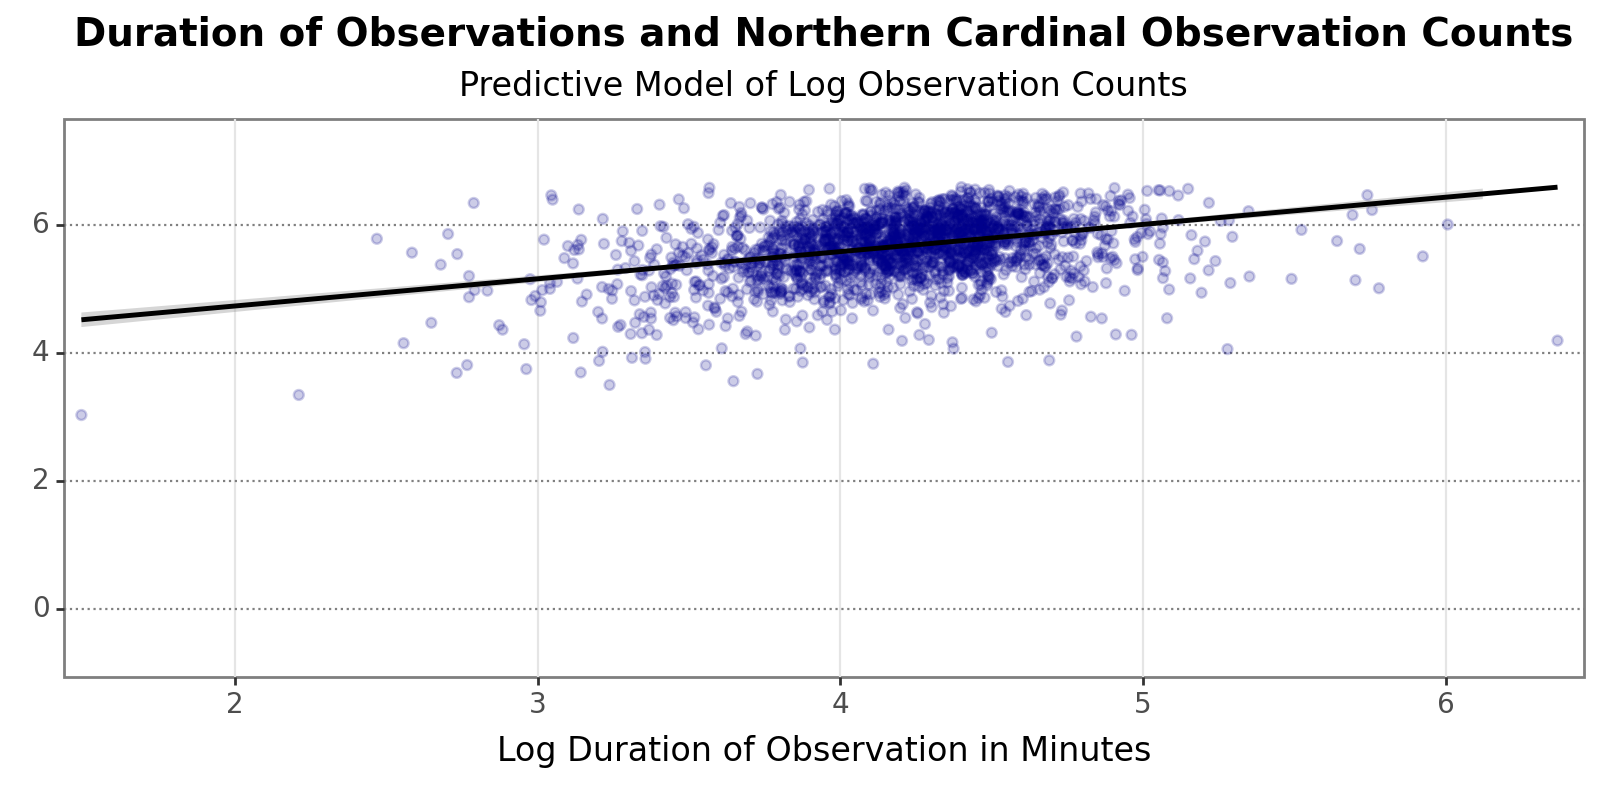



________________________________________________________________________________________________________________________




C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning:

geom_jitter : Removed 118 rows containing missing values.



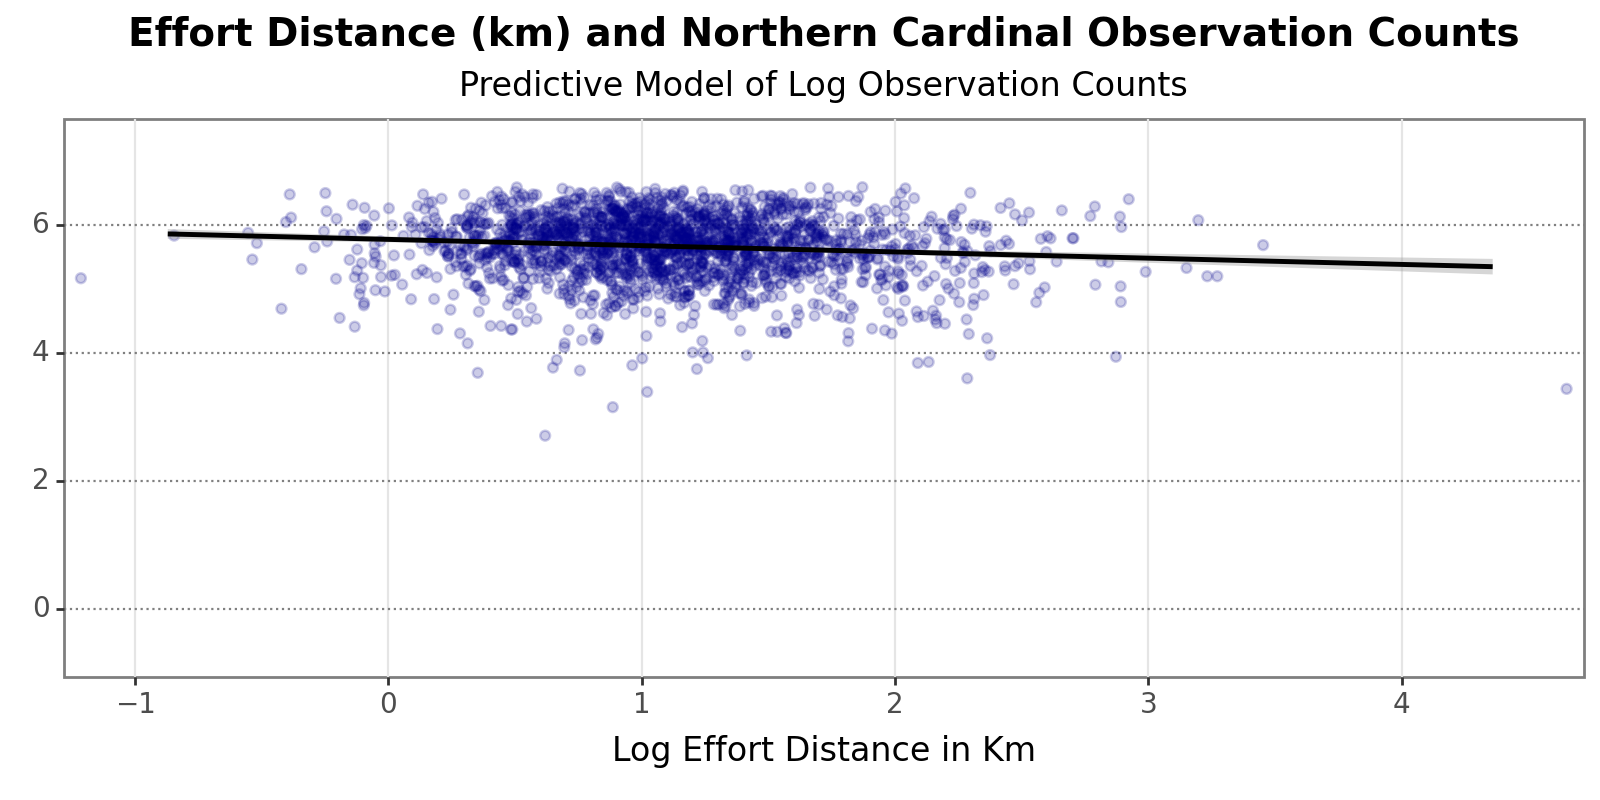

In [843]:
# Use the regression model to predict 'OBSERVATION_COUNT' based on the dataset
pred = reg31.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

# Plotting the predictions along with their confidence intervals
plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="ln_DURATION_MINUTES", y="fit")) +
    geom_jitter(alpha=0.2, size=1.5, color='darkblue') +  # Muted green color
    geom_smooth(method='lm', color='black', se=True) +  # Smoothing line for regression
    labs(
        title="Duration of Observations and Northern Cardinal Observation Counts",
        subtitle="Predictive Model of Log Observation Counts",
        x="Log Duration of Observation in Minutes",
        y=""
    ) +
    theme_bw(base_size=12) +  # Minimal theme with base font size
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        legend_position="none",  # Hide legend (if not necessary)
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_grid_major_y=element_line(color="grey", linetype="dotted"),  # Dotted major grid lines on y-axis
        figure_size=(8, 4)  # Aspect ratio of the plot, adjusted to your preference
    ) +
    scale_x_continuous(expand=(0.01, 0.01)) +  # Slight expansion for padding
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].quantile(0.95)),  # Limits for y-axis
        expand=(0.01, 1)  # Slight expansion for padding on y-axis
    )
)


# Plotting the predictions along with their confidence intervals
plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x="ln_EFFORT_DISTANCE_KM", y="fit")) +
    geom_jitter(alpha=0.2, size=1.5, color='darkblue') +  # Muted green color
    geom_smooth(method='lm', color='black', se=True) +  # Smoothing line for regression
    labs(
        title="Effort Distance (km) and Northern Cardinal Observation Counts",
        subtitle="Predictive Model of Log Observation Counts",
        x="Log Effort Distance in Km",
        y=""
    ) +
    theme_bw(base_size=12) +  # Minimal theme with base font size
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        legend_position="none",  # Hide legend (if not necessary)
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_grid_major_y=element_line(color="grey", linetype="dotted"),  # Dotted major grid lines on y-axis
        figure_size=(8, 4)  # Aspect ratio of the plot, adjusted to your preference
    ) +
    scale_x_continuous(expand=(0.01, 0.01)) +  # Slight expansion for padding
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].quantile(0.95)),  # Limits for y-axis
        expand=(0.01, 1)  # Slight expansion for padding on y-axis
    )
)


print(plot1) # duration of observations predictive model
print("\n" + "_"*120 + "\n\n")
print(plot2) # effort distance in km predictive model